# Import packages

In [22]:
import ast
import os
import warnings
import re
from datetime import datetime

import isort
import emoji
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, date2num
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import statsmodels as sm
from arch import arch_model
from pmdarima.arima import auto_arima
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA

from functions import *
from scripts import *

warnings.simplefilter(action='ignore', category=FutureWarning)
set_plot_style()
np.random.seed(42)

<Figure size 3600x1800 with 0 Axes>

# Import datasets

In [23]:
data = import_and_preprocess_data_stock(symbol="AAPL")
data.head()

Date       Open       High        Low      Close  \
0 2013-01-02 00:00:00-05:00  16.814443  16.850269  16.444345  16.669014   
1 2013-01-03 00:00:00-05:00  16.634106  16.688452  16.425223  16.458620   
2 2013-01-04 00:00:00-05:00  16.302868  16.353267  15.964647  16.000170   
3 2013-01-07 00:00:00-05:00  15.848357  16.069990  15.641903  15.906043   
4 2013-01-08 00:00:00-05:00  16.067263  16.148630  15.825592  15.948855   

      Volume  Dividends  Stock Splits  Volatility    Return  Log_Return  
0  560518000        0.0           0.0    0.405924       NaN         NaN  
1  352965200        0.0           0.0    0.263229 -0.012622   -0.012702  
2  594333600        0.0           0.0    0.388620 -0.027855   -0.028250  
3  484156400        0.0           0.0    0.428087 -0.005883   -0.005900  
4  458707200        0.0           0.0    0.323039  0.002692    0.002688

## Data Processing & Sentiment Annotation

> **Note:** Due to the heavy computation involved, all preprocessing and model-based sentiment labeling were executed on Google Colab, not within this local project. The resulting DataFrame is saved as `tweets_processed_with_sentiment.parquet` in the `data/` folder. You can access to the functions used for preprocessing in `scripts/scripts/compute_sentiment_analysis.py`.

Below is a concise overview of how the Parquet file was generated. All steps have already been applied.

## 0. Data
- **`tweets`**  
  - Contains tweets with columns:  
    - `Date` (timestamp)
    - `body` (text content)  
    - `entities` (containing sentiment labels, e.g. “Bullish” or “Bearish”)  
  - The DataFrame is loaded from `data/tweets_aggregated.parquet`.

## 1. Likes Preprocessing
- **`extract_likes()`**  
  - Parses a stringified dictionary (e.g. `"{'total': 42}"`) and returns the `"total"` value.  
  - Returns **0** if input is `None`, `NaN`, or malformed.
- **`add_likes_ponderation()`**  
  - Computes `likes_ponderation = sqrt(1 + likes_total)`  
  - This transformation dampens the effect of tweets with very high like counts.

## 2. Base Sentiment Extraction
- **`extract_sentiment_base()`**  
  - Scans an existing `sentiment` column for “Bullish” or “Bearish.”  
  - Creates `sentiment_base` containing only **“Bullish”**, **“Bearish”**, or `NaN`.

## 3. Text Cleaning (common to all models)
- **`clean_text()`**  
  1. Remove URLs (`http://…` or `https://…`).  
  2. Replace `&#39;` with an apostrophe (`'`).  
  3. Convert `#Tag` → `hashtag_Tag`.  
  4. Convert `$AAPL` → `cashtag_AAPL`.  
  5. Convert `@user` → `mention_user`.  
  6. Convert emojis to text (e.g. 😊 → `:smiling_face:`).  
  7. Trim leading/trailing whitespace.  
- The cleaned string is stored in **`body_cleaned`**.

## 4. Transformer‐Based Sentiment Labeling
- **RoBERTa** (`zhayunduo/roberta-base-stocktwits-finetuned`)  
  - Input: `body_cleaned`  
  - GPU‐accelerated batch inference (max length = 512 tokens)  
  - Outputs “Bullish” or “Bearish” in **`sentiment_roberta`**.
- **FinBERT** (`ProsusAI/finbert`)  
  - Input: `body_cleaned`  
  - GPU‐accelerated batch inference (max length = 512 tokens)  
  - Outputs one of three classes:  
    - `0` → **“Bearish”**  
    - `1` → **“Neutral”**  
    - `2` → **“Bullish”**  
  - Stored in **`sentiment_finbert`**.

## 5. Lexicon‐Based Sentiment Labeling
- **VADER** (`SentimentIntensityAnalyzer`)  
  1. Computes a compound score ∈ [–1, +1] on `body_cleaned`.  
  2. Applies thresholds:  
     - ≥ 0.05 → **“Bullish”**  
     - ≤ –0.05 → **“Bearish”**  
     - Otherwise → **“Neutral”**  
  3. Stores the discrete label in **`sentiment_vader`**.

## Newly Created Columns
- **`sentiment_base`**  
- **`body_cleaned`**  
- **`likes_total`** (original like counts)  
- **`likes_ponderation`**  
- **`sentiment_vader`**  
- **`sentiment_finbert`**  
- **`sentiment_roberta`**

In [24]:
tweets = pd.read_parquet("data/tweets_processed_with_sentiment.parquet")
tweets.head()

id                                               body        date  \
0  188952625  $AAPL there is some smarty money trimming into...  2020-01-03   
1  188952404                                        $AAPL boom!  2020-01-03   
2  188952295       $AAPL this pos will not fall below mid VWAP.  2020-01-03   
3  188952260  $AAPL  I am holding going to see what this bab...  2020-01-03   
4  188951817  $SPY is $AAPL over priced is the average analy...  2020-01-03   

                                                user  \
0  {'id': 646025, 'username': 'WalterWhitesMoney'...   
1  {'id': 2975791, 'username': 'IntradayTradesmen...   
2  {'id': 2975791, 'username': 'IntradayTradesmen...   
3  {'id': 2083522, 'username': 'robertlooney', 'n...   
4  {'id': 1581841, 'username': 'CaymanStyleBeef',...   

                                              source  \
0  {'id': 1149, 'title': 'StockTwits for iOS', 'u...   
1  {'id': 1149, 'title': 'StockTwits for iOS', 'u...   
2  {'id': 1149, 'title': 'StockTwits for iOS', 'u...   
3  {'id': 2095, 'title': 'StockTwits For Android ...   
4  {'id': 2095, 'title': 'StockTwits For Android ...   

                                             symbols  \
0  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
1  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
2  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
3  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
4  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   

                                       owned_symbols mentioned_users  \
0  ['9', '4', '5', '0', '5', '12', '0', '0', '0',...              []   
1  ['21', '12', '9', '0', '9', '5', '0', '4', '0'...              []   
2  ['20', '11', '9', '0', '9', '5', '0', '4', '0'...              []   
3  ['4', '4', '0', '0', '0', '3', '0', '0', '0', ...              []   
4  ['3', '2', '1', '0', '1', '1', '0', '1', '0', ...              []   

                              entities  \
0                  {'sentiment': None}   
1                  {'sentiment': None}   
2                  {'sentiment': None}   
3  {'sentiment': {'basic': 'Bullish'}}   
4                  {'sentiment': None}   

                                        conversation  ... reshares  \
0                                               None  ...     None   
1                                               None  ...     None   
2  {'parent_message_id': 188952295, 'in_reply_to_...  ...     None   
3                                               None  ...     None   
4  {'parent_message_id': 188951817, 'in_reply_to_...  ...     None   

  reshare_message structurable sentiment_base  \
0            None         None            nan   
1            None         None            nan   
2            None         None            nan   
3            None         None        Bullish   
4            None         None            nan   

                                        body_cleaned likes_total  \
0  cashtag_AAPL there is some smarty money trimmi...           0   
1                                 cashtag_AAPL boom!           0   
2  cashtag_AAPL this pos will not fall below mid ...           0   
3  cashtag_AAPL  I am holding going to see what t...           1   
4  cashtag_SPY is cashtag_AAPL over priced is the...           0   

  likes_ponderation  sentiment_vader  sentiment_finbert sentiment_roberta  
0          1.000000          Neutral            Bullish           Bearish  
1          1.000000          Neutral            Bullish           Bullish  
2          1.000000          Neutral            Bullish           Bearish  
3          1.414214          Bullish            Bullish           Bullish  
4          1.000000          Neutral            Bullish           Bearish  

[5 rows x 22 columns]

# EDA

## EDA - Apple Stock Price

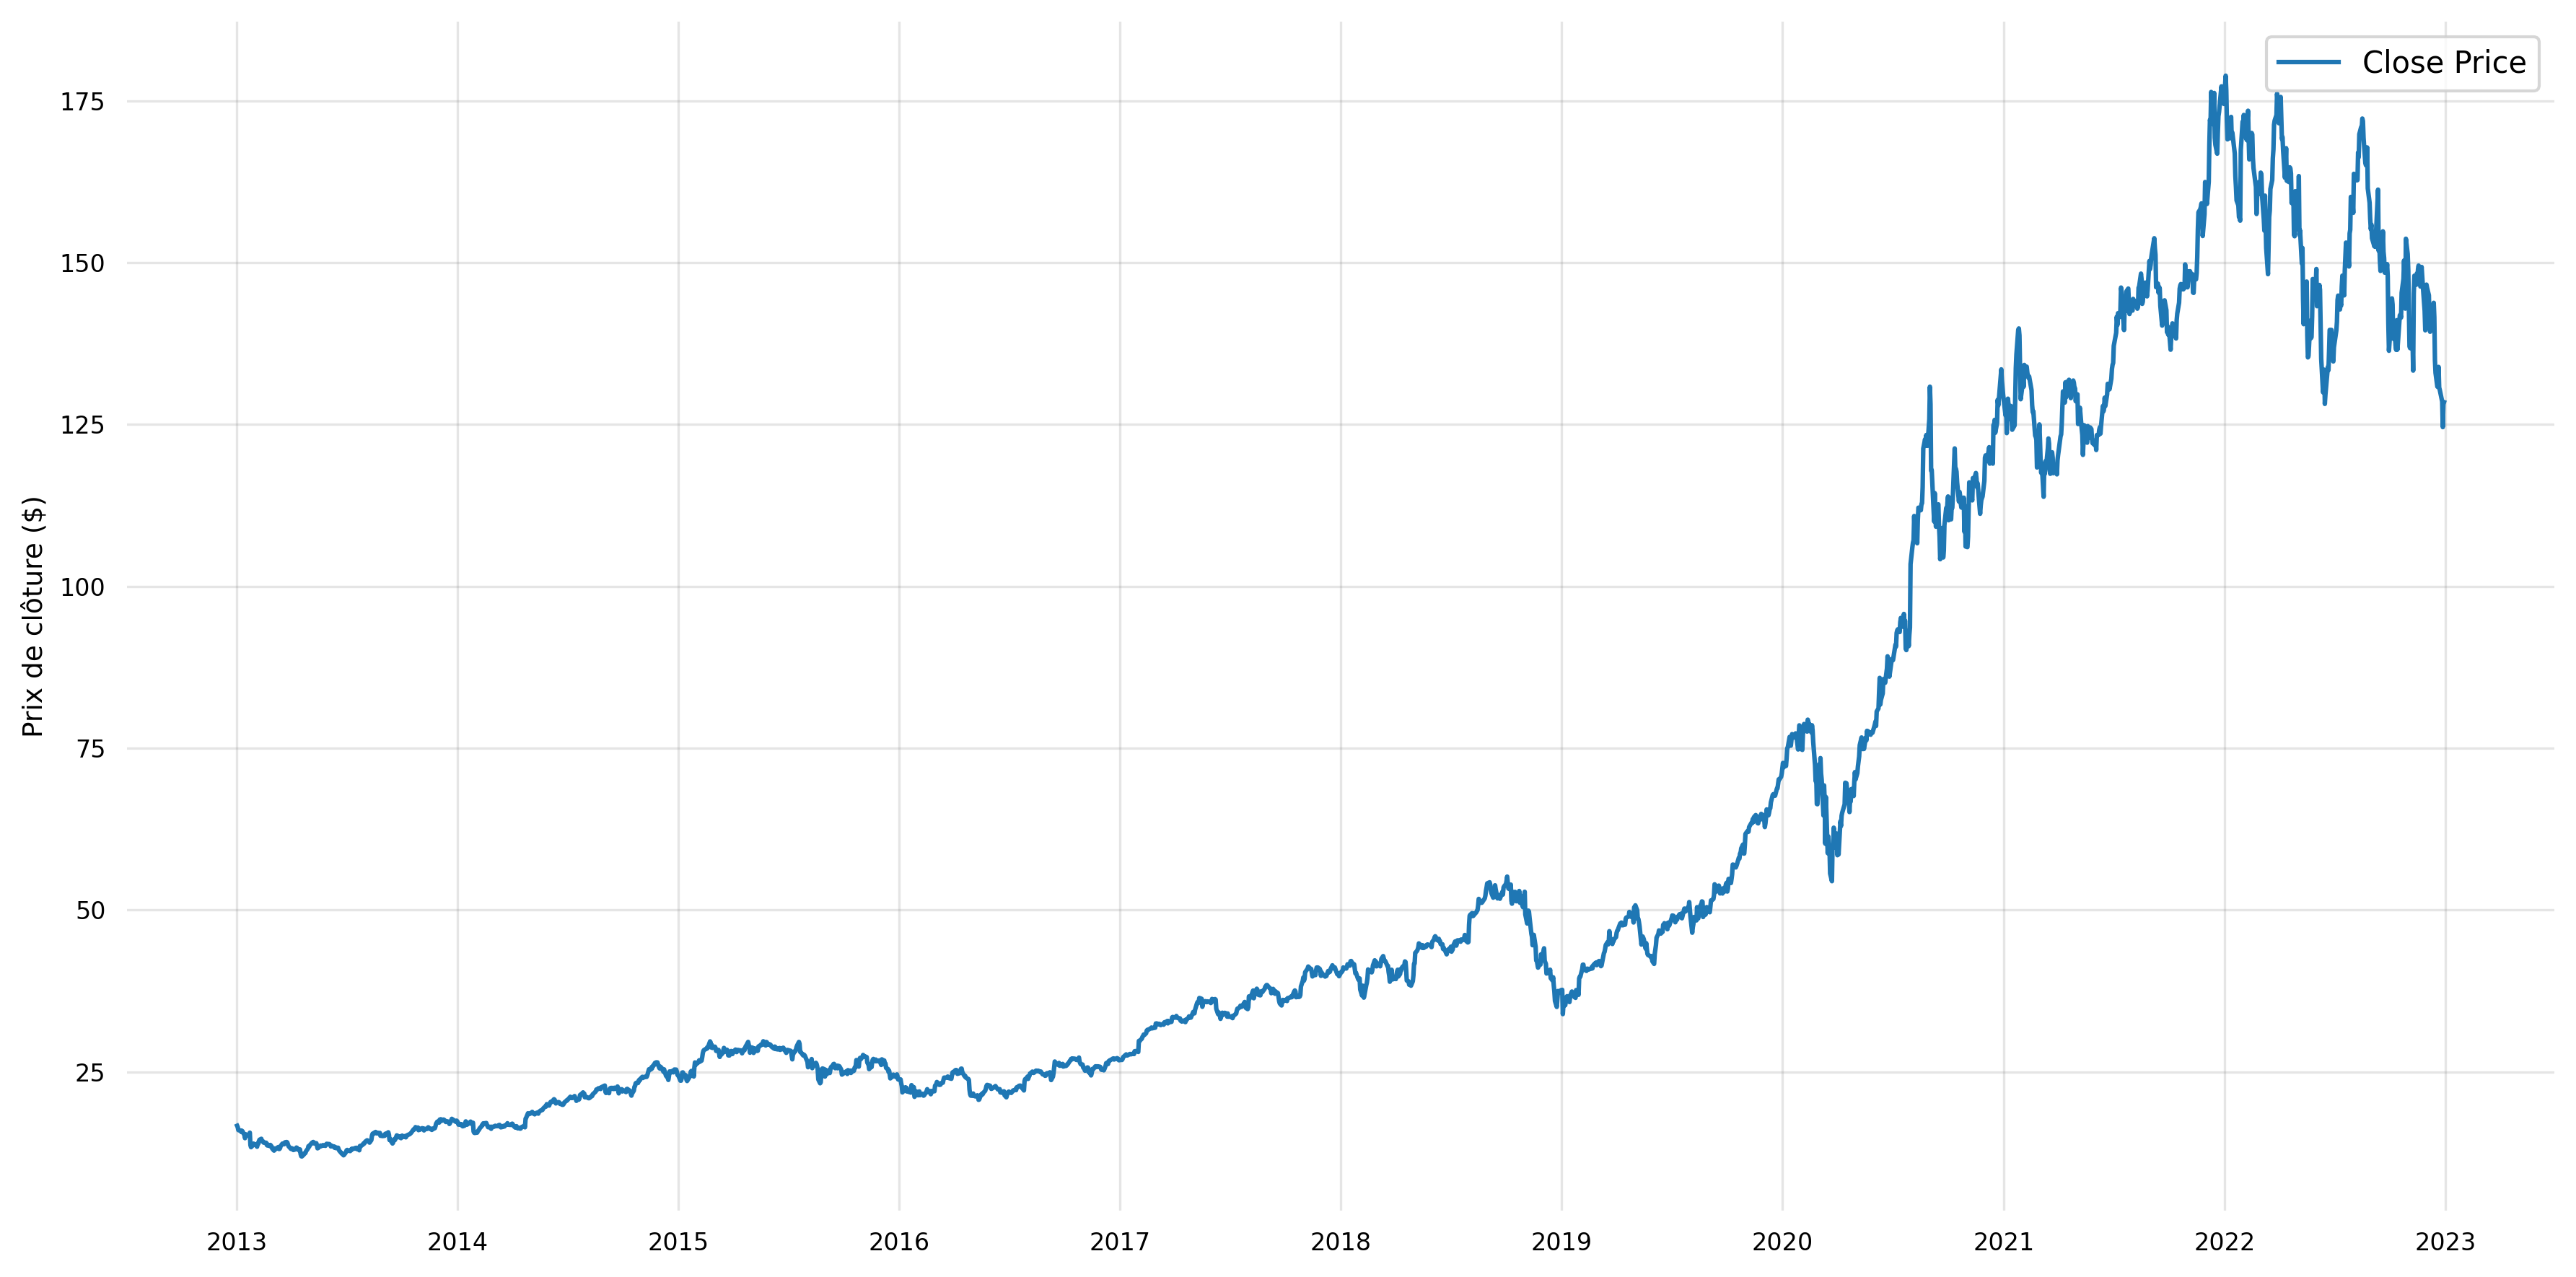

In [4]:
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.ylabel("Prix de clôture ($)")
plt.legend()
plt.tight_layout()
plt.show()

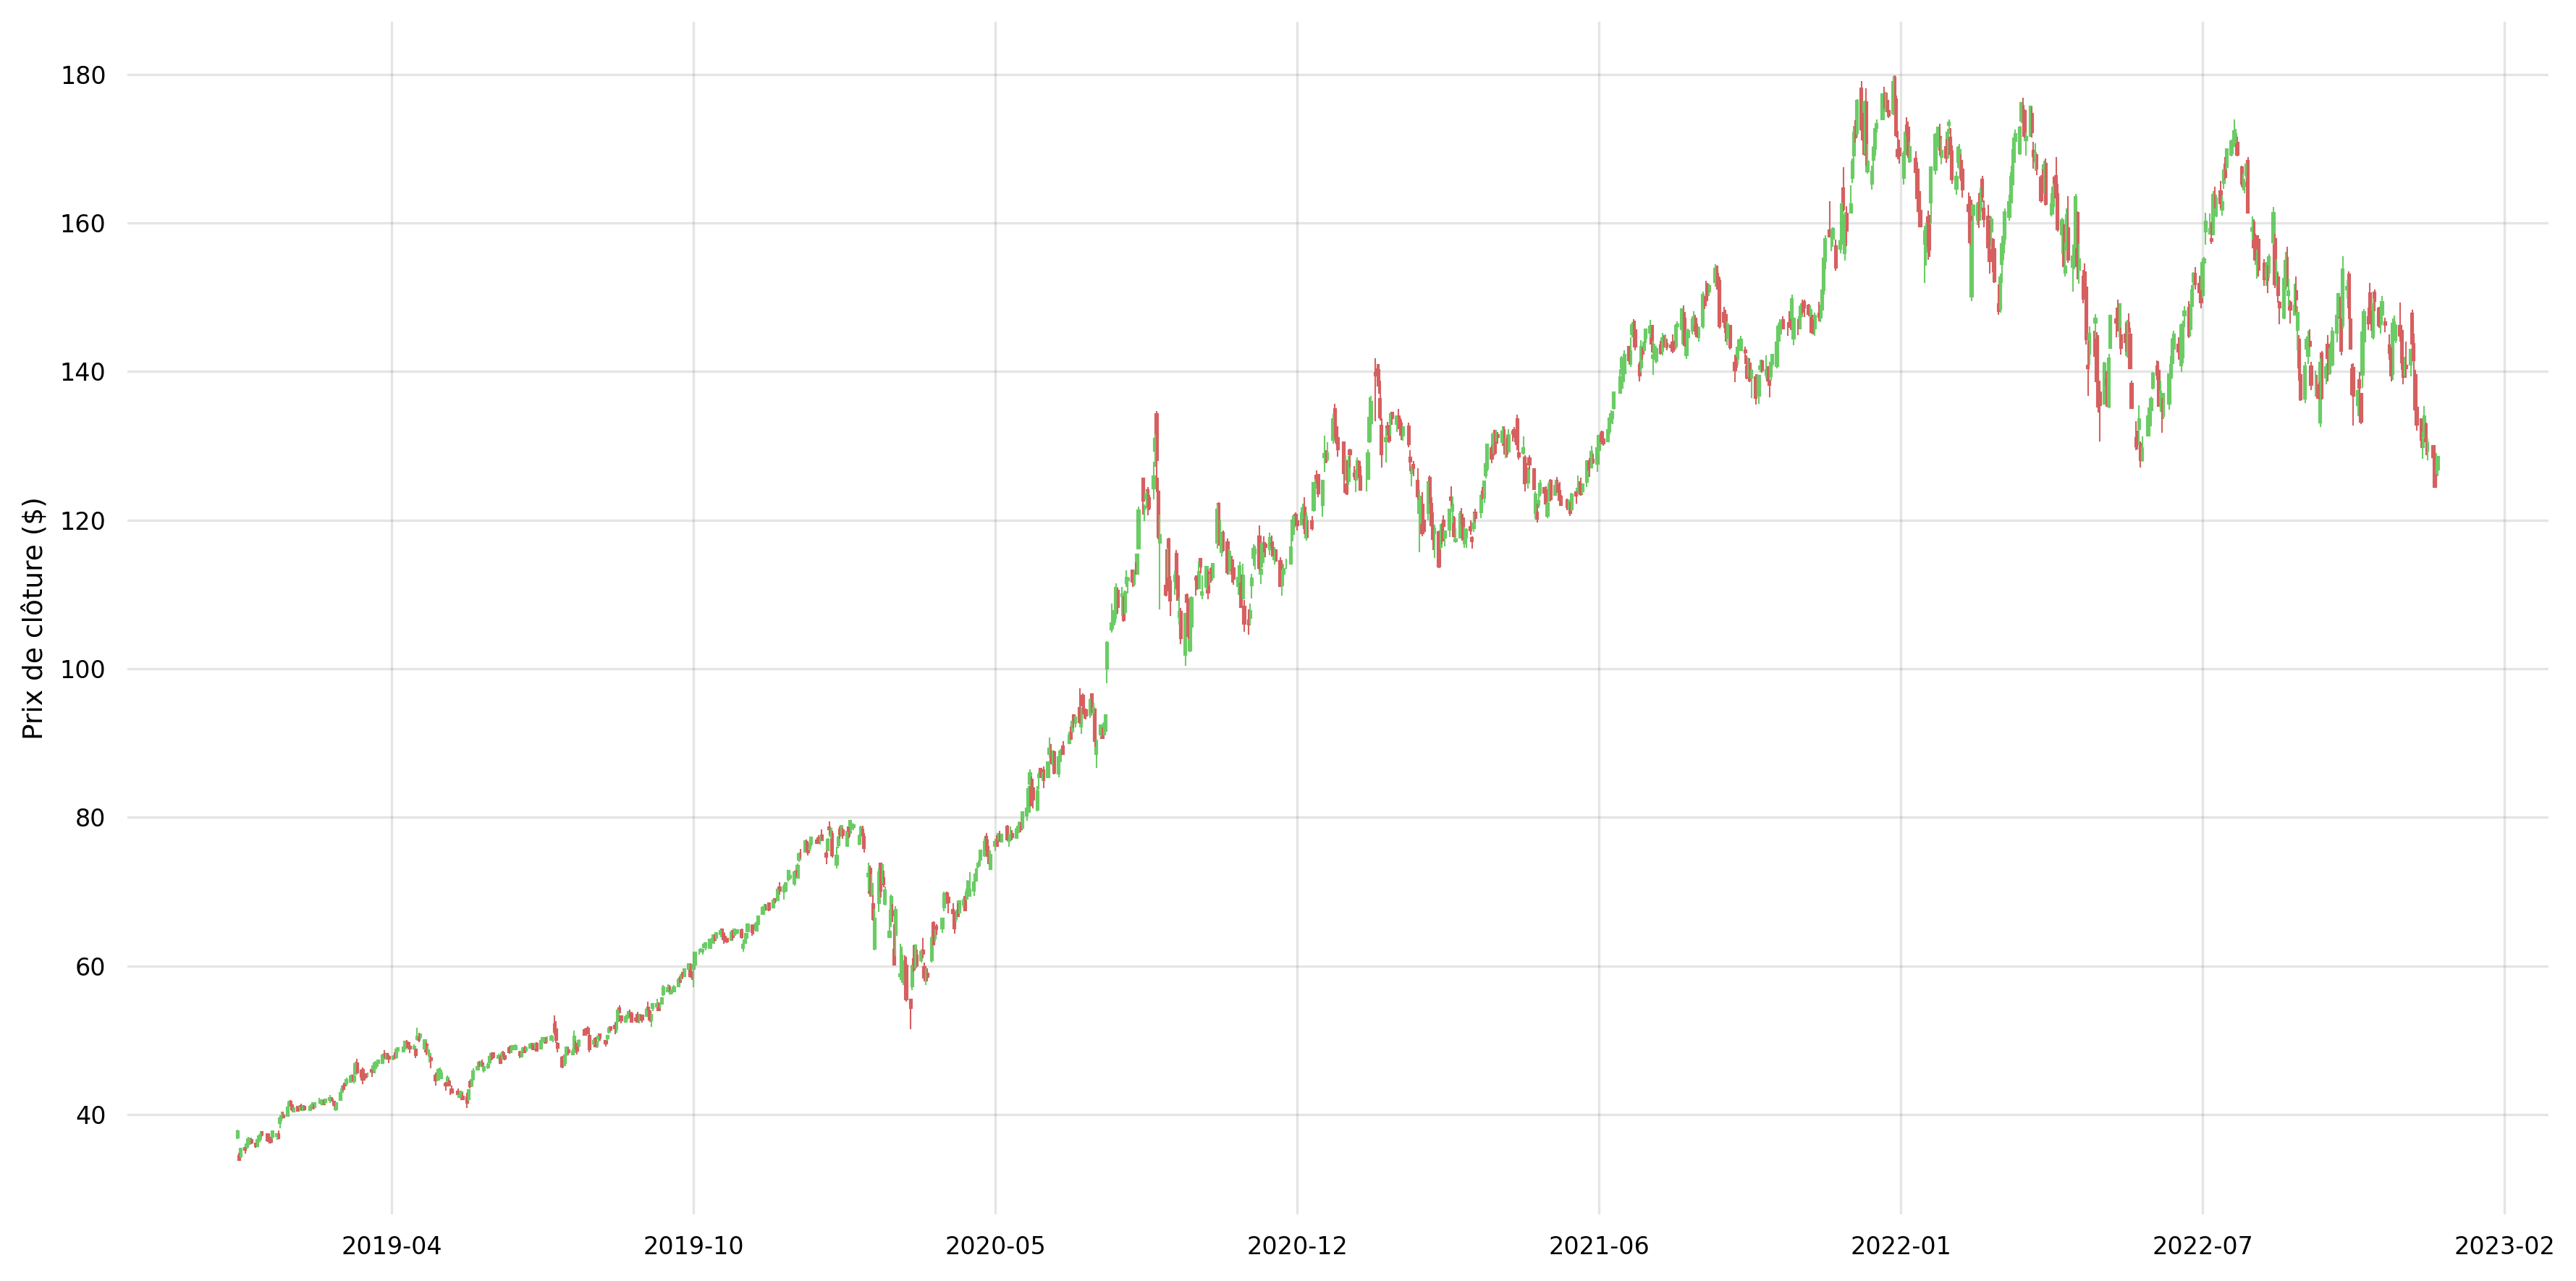

In [ ]:

data['Date_num'] = date2num(data['Date'])
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA2'] = data['Close'].rolling(window=2).mean()
quotes = [tuple(x) for x in data[['Date_num', 'Open', 'High', 'Low', 'Close']].values]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))  # You can set tight layout manually
from mplfinance.original_flavor import candlestick_ohlc
candlestick_ohlc(ax, quotes, width=0.6, colorup='g', colordown='r')

# Format x-axis
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.ylabel("Prix de clôture ($)")
# Tight layout
plt.tight_layout()
plt.show()

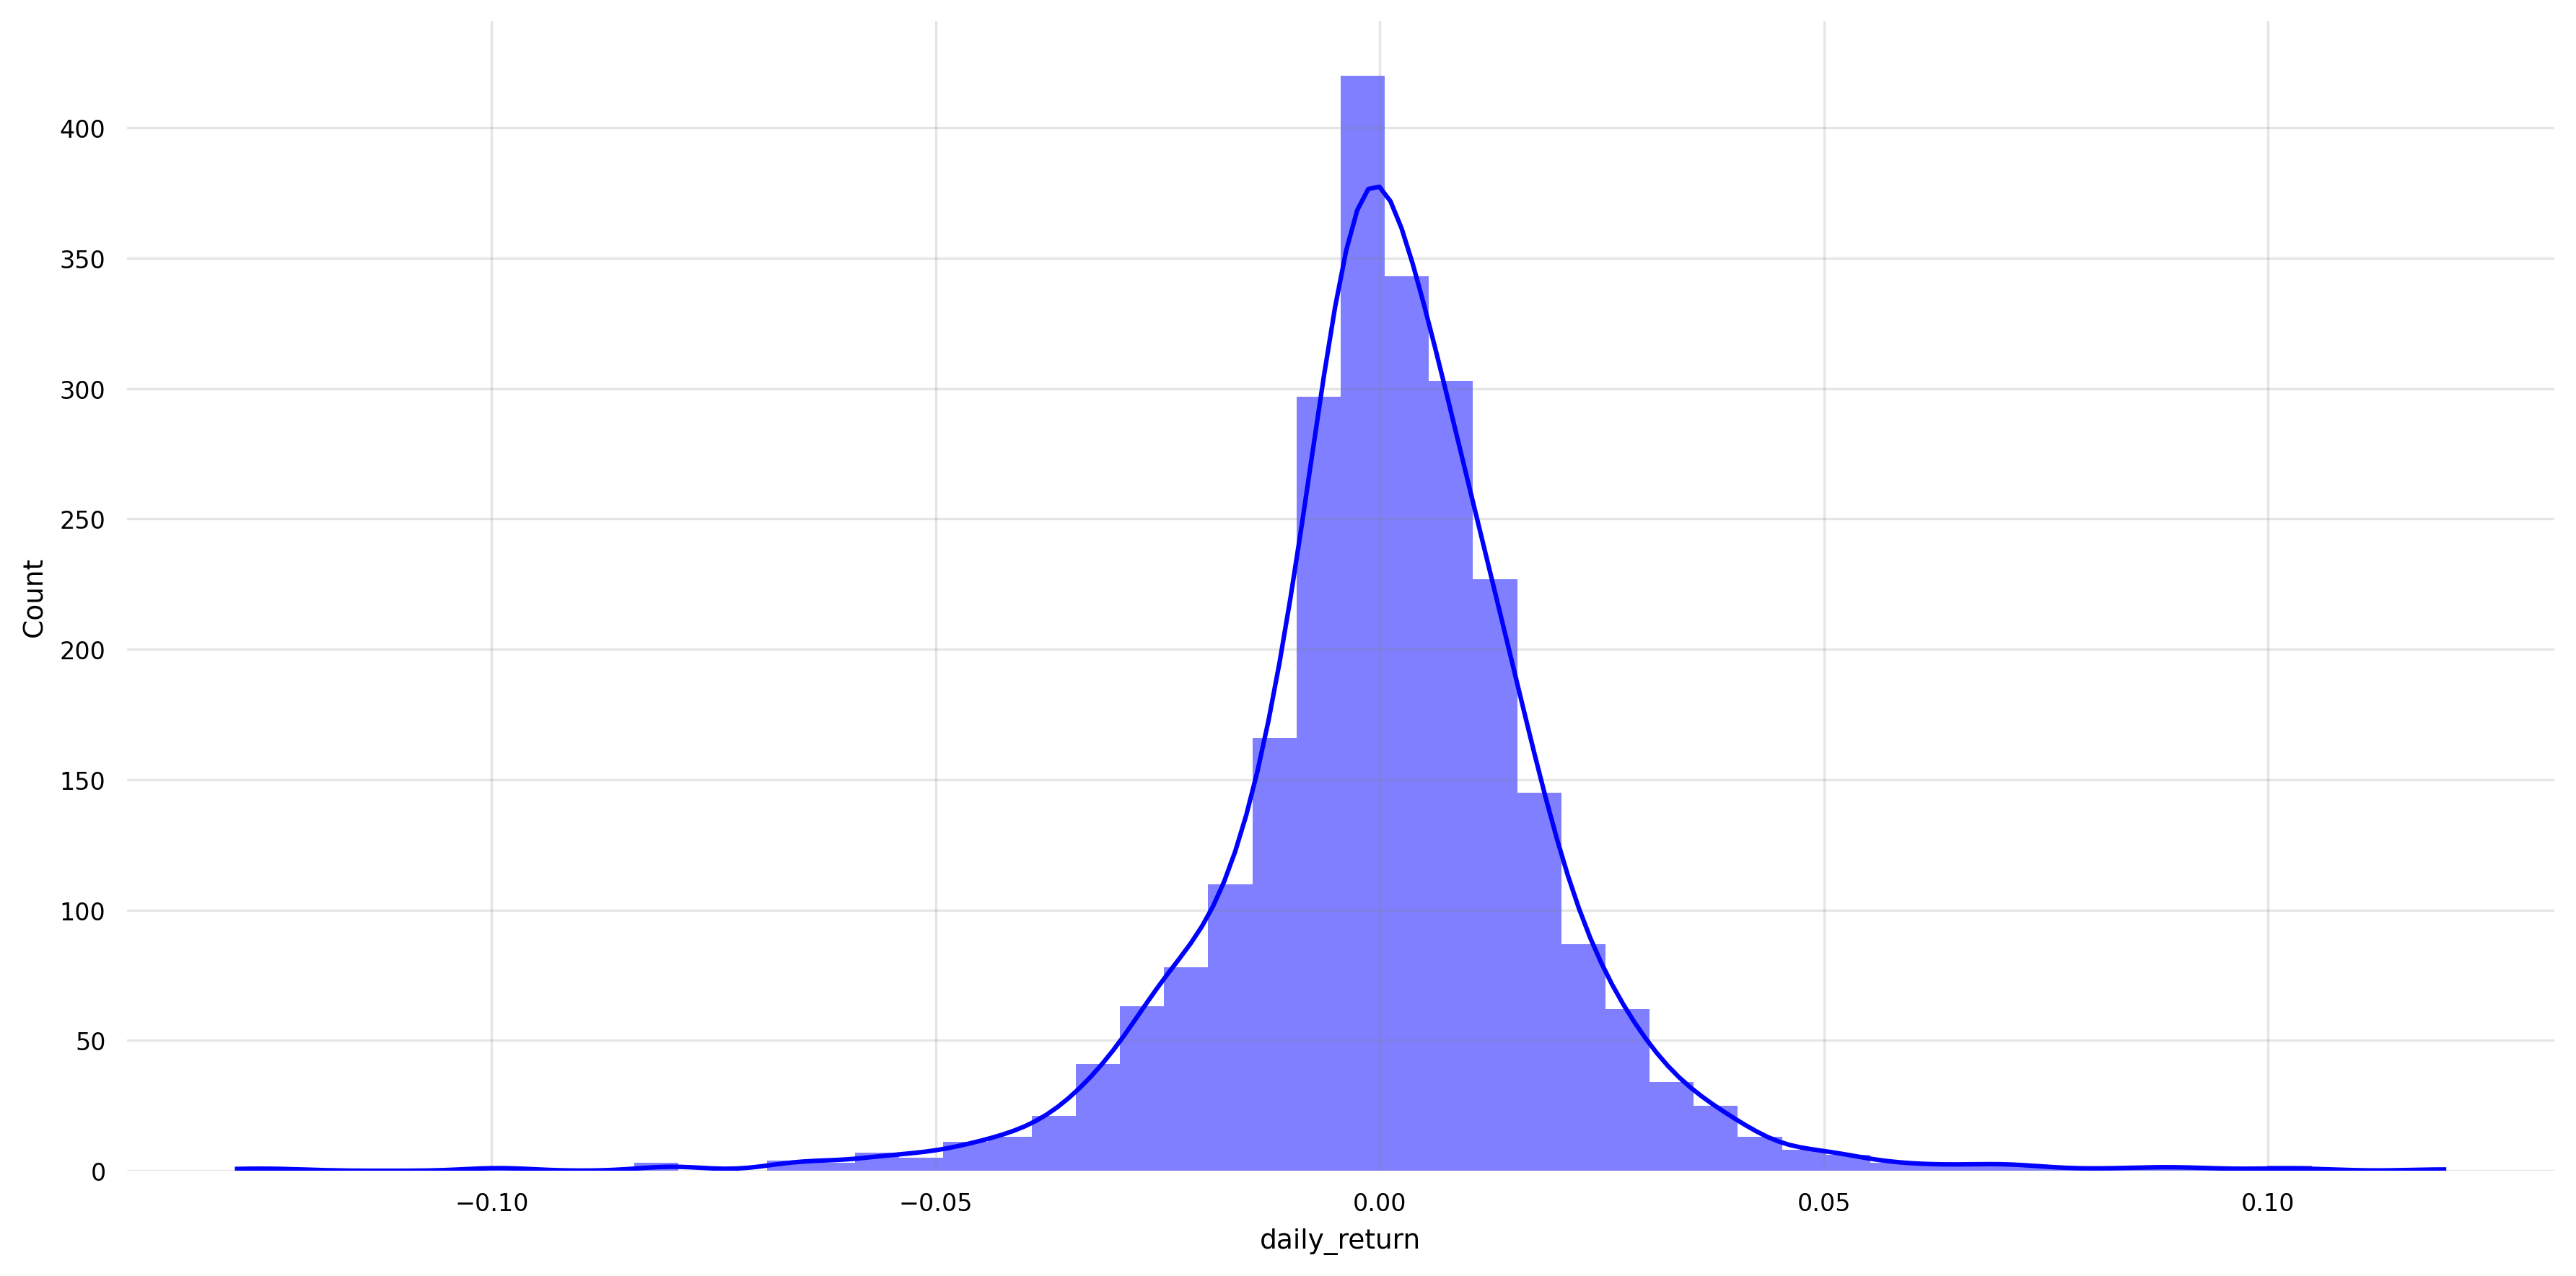

In [25]:
data['daily_return'] = data['Close'].pct_change()
sns.histplot(data['daily_return'], bins=50, kde=True, alpha=0.5, color='blue', edgecolor=None)
plt.tight_layout()

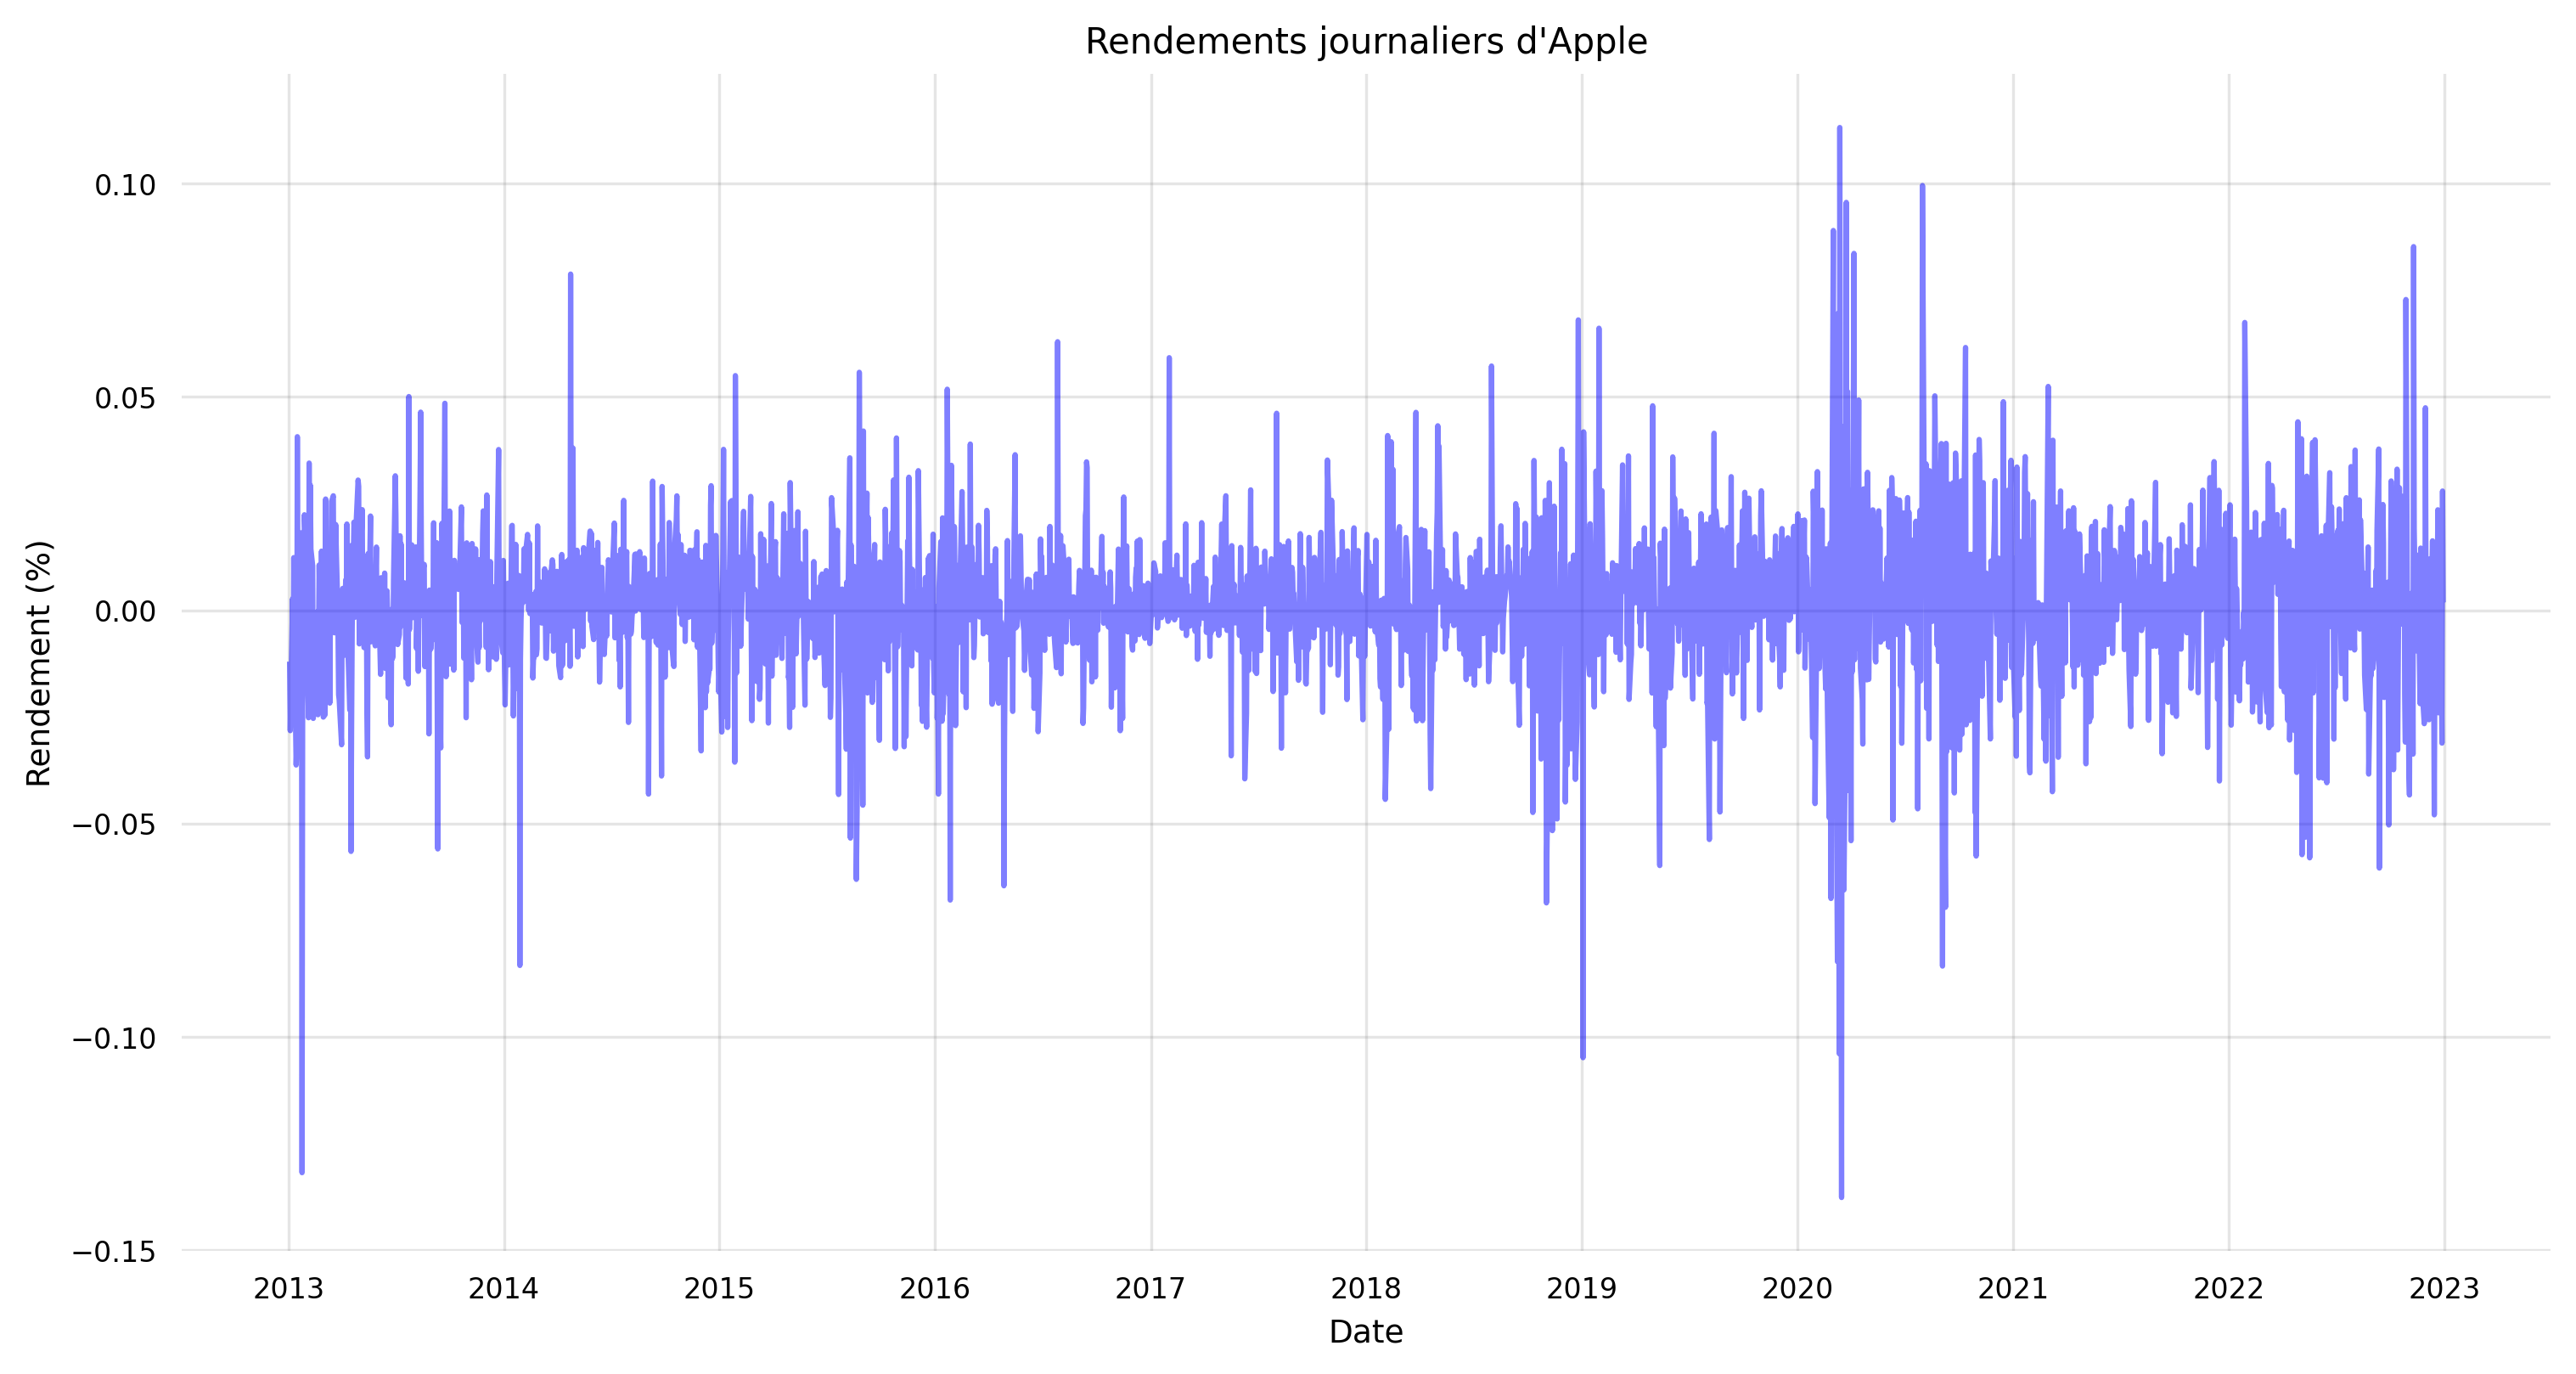

In [55]:
plt.plot(data['Date'], data['Log_Return'], color="blue", alpha=0.5)
plt.title("Rendements journaliers d'Apple")
#plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Rendement (%)")
plt.show()


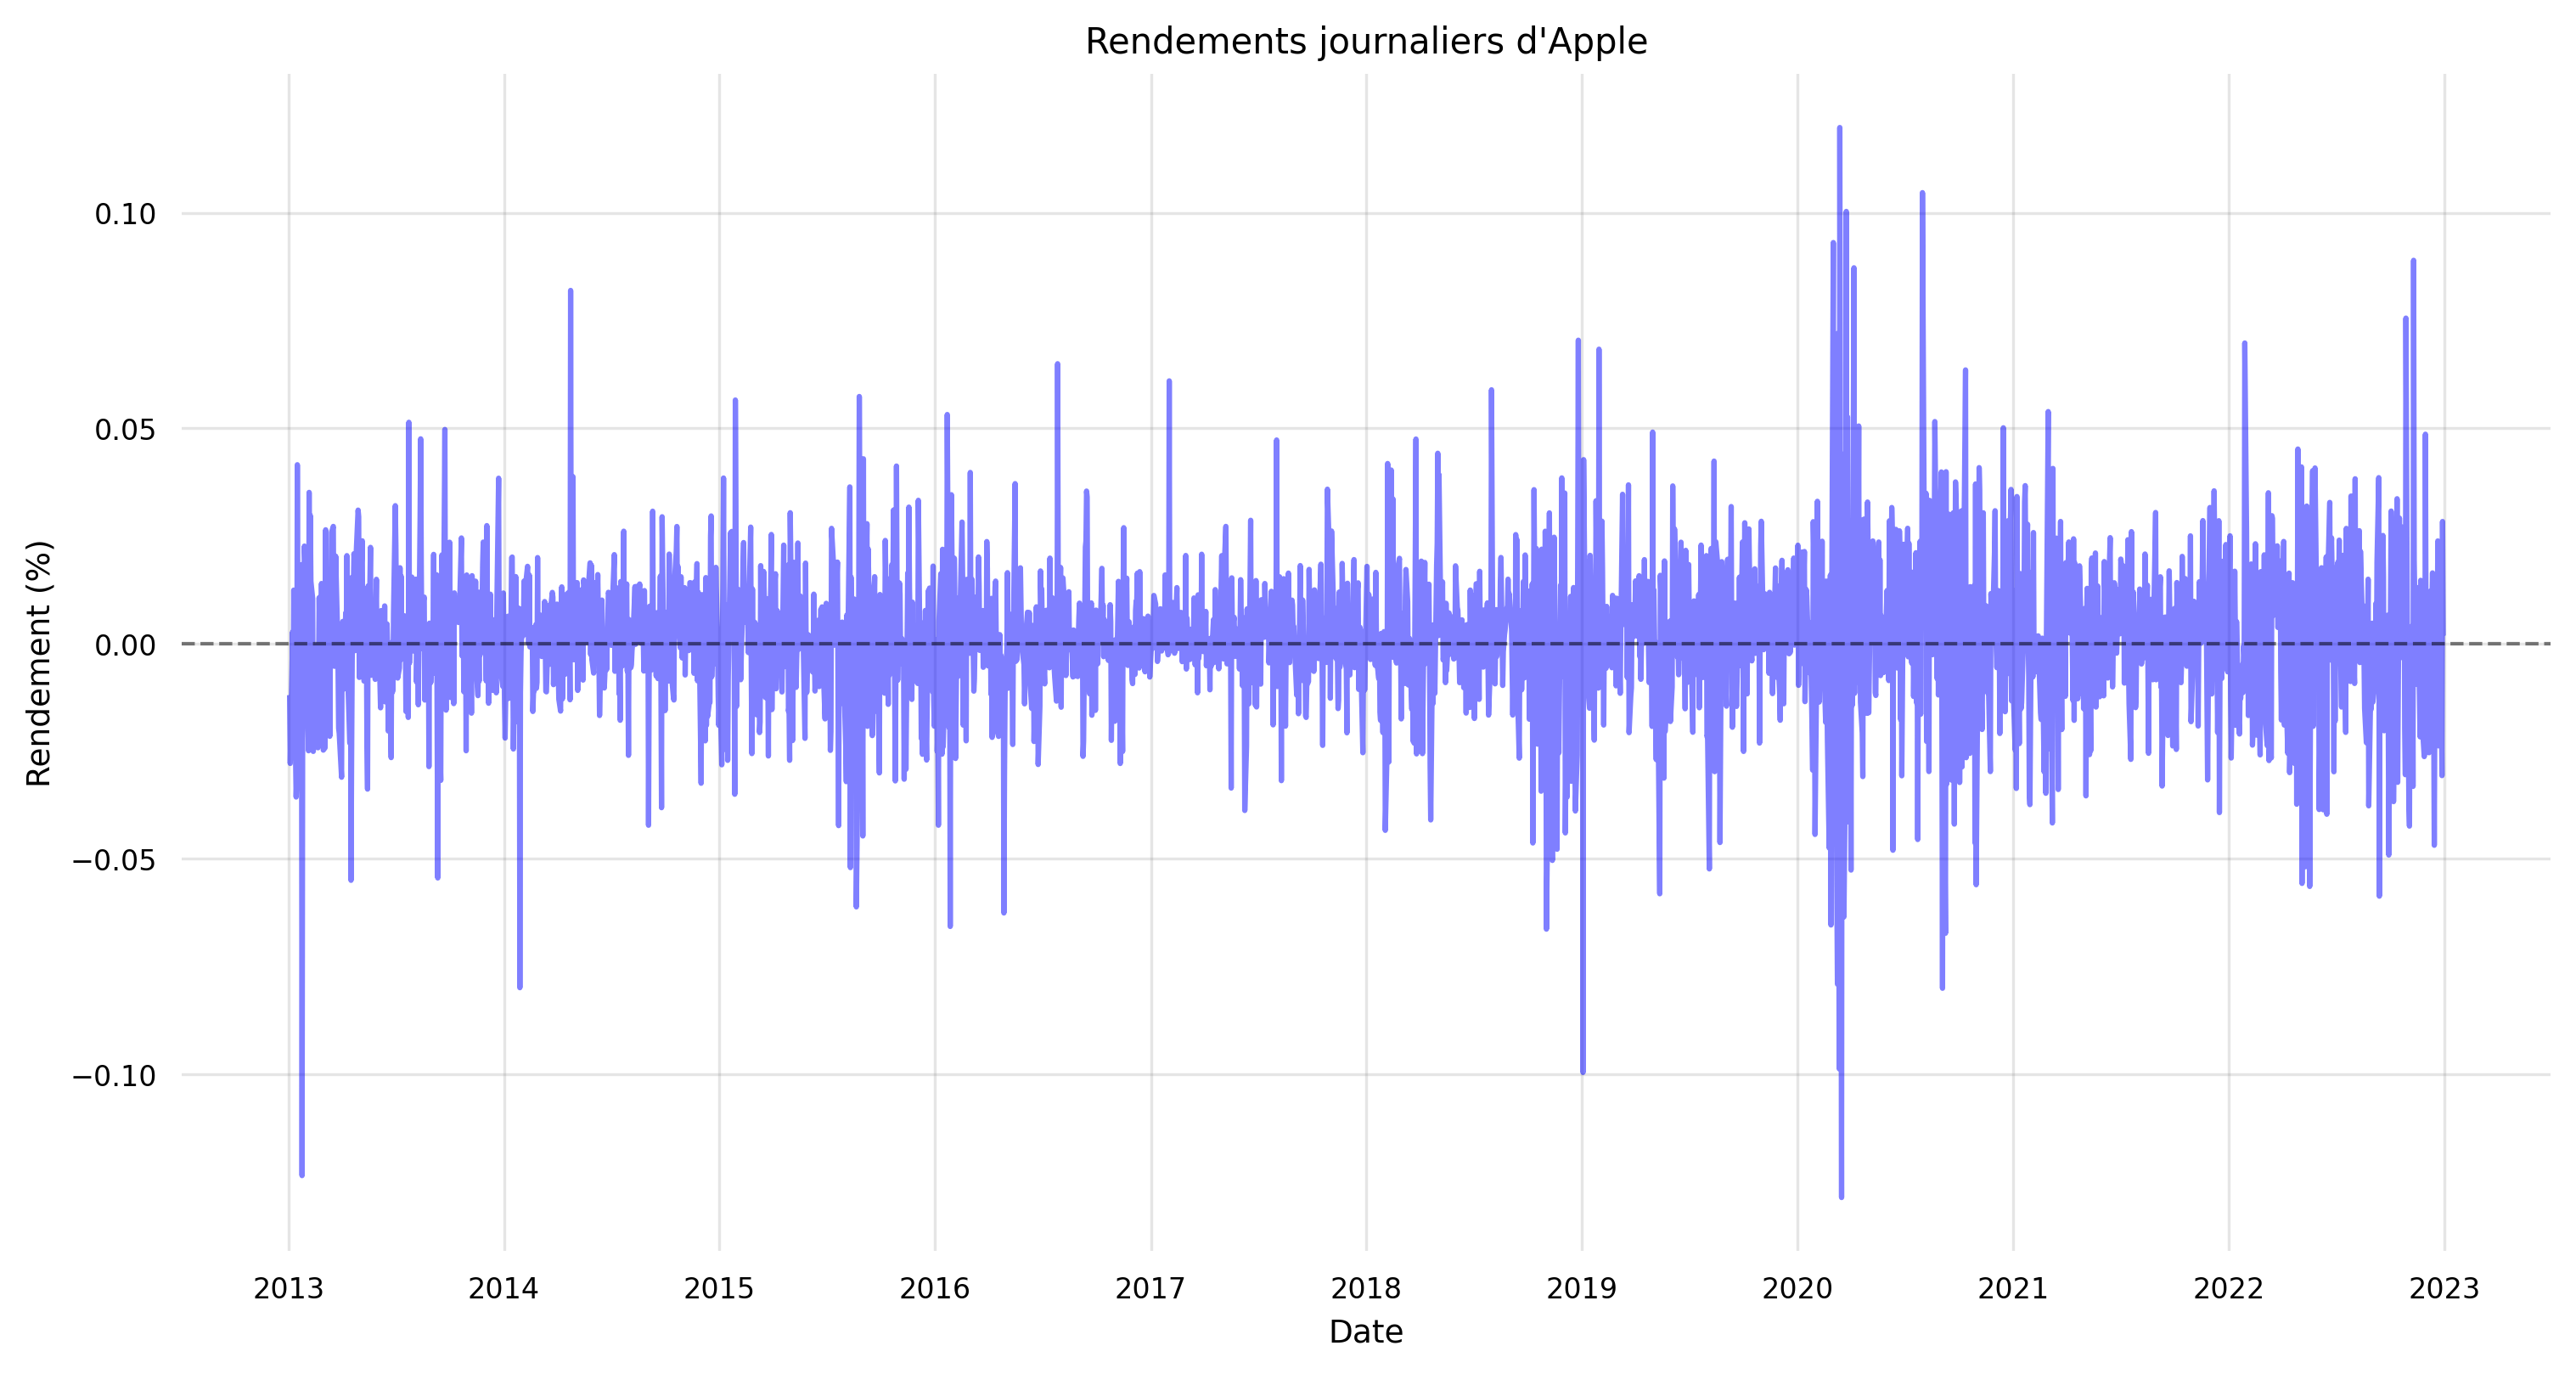

In [26]:
plt.plot(data['Date'], data['daily_return'], color="blue", alpha=0.5)
plt.title("Rendements journaliers d'Apple")
plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Rendement (%)")
plt.show()


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume `data` is your DataFrame
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Use Pandas Styler to apply a heatmap style
styled_corr = correlation_matrix.style.background_gradient(cmap='coolwarm')

styled_corr

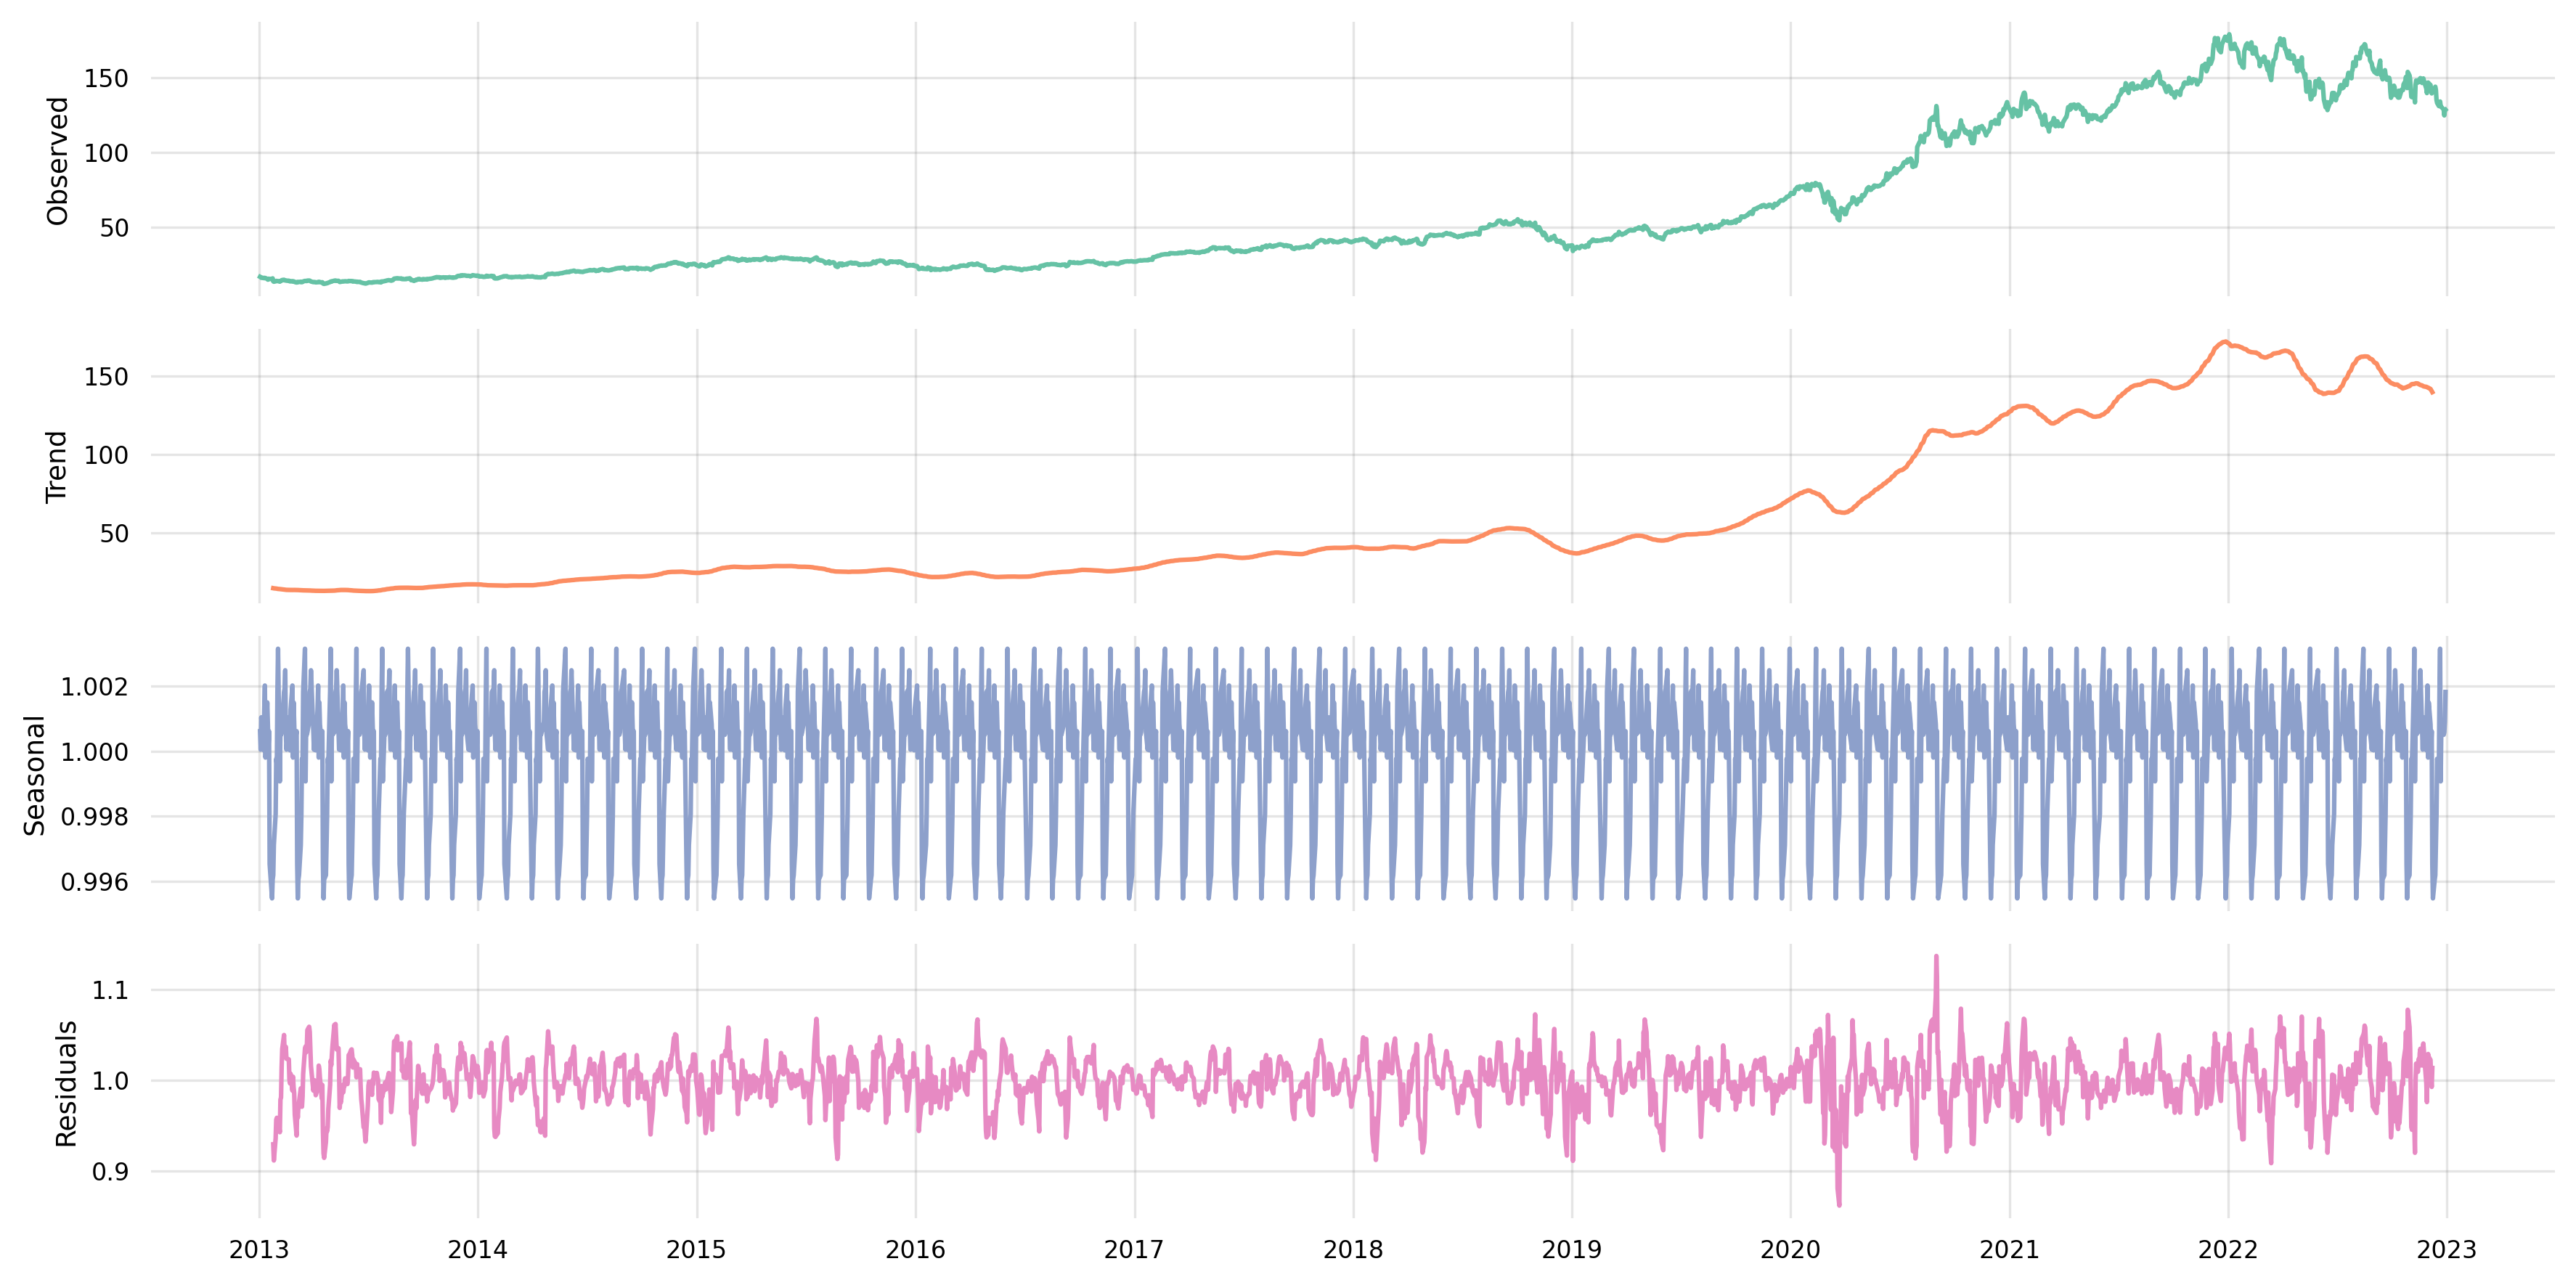

In [27]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Effectuer la décomposition
result = seasonal_decompose(data.set_index('Date')['Close'], model='multiplicative', period=30)

# Initialiser la figure avec 4 sous-graphes
fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)
components = ['observed', 'trend', 'seasonal', 'resid']
titles = ['Observed', 'Trend', 'Seasonal', 'Residuals']
colors = px.colors.qualitative.Plotly[:4]
colors = sns.color_palette("Set2")[:4]
# Tracer chaque composante
for ax, comp, title, color in zip(axes, components, titles, colors):
    series = getattr(result, comp)
    ax.plot(series, label=title, color=color)
    ax.set_ylabel(title)
    ax.grid(True)

# Titre général et ajustement
plt.tight_layout() 
plt.show()


In [66]:
90/len(data)

0.16574585635359115

In [72]:
data.iloc[int(0.83*len(data)):]

Date        Open        High         Low       Close     Volume  \
2212  2021-10-14  139.462547  141.199577  138.873719  141.081802   69907100   
2213  2021-10-15  141.091650  142.200588  140.836484  142.141708   67940300   
2214  2021-10-18  140.777585  144.104430  140.492994  143.819839   85589200   
2215  2021-10-19  144.271219  146.390982  143.819797  145.988617   76378900   
2216  2021-10-20  145.929790  146.960232  145.360593  146.479355   58418800   
...          ...         ...         ...         ...         ...        ...   
2300  2022-02-18  167.112192  167.820698  163.540069  164.632370   82772700   
2301  2022-02-22  162.349355  164.032095  159.564478  161.699890   91162800   
2302  2022-02-23  162.900452  163.500726  157.202780  157.517685   90009200   
2303  2022-02-24  150.147095  160.253342  149.576341  160.145096  141147500   
2304  2022-02-25  161.227576  162.487165  158.304931  162.221481   91974200   

      Dividends  Stock Splits  Volatility    Return  Log_Return  
2212        0.0           0.0    2.325858  0.020225    0.020024  
2213        0.0           0.0    1.364104  0.007513    0.007485  
2214        0.0           0.0    3.611436  0.011806    0.011737  
2215        0.0           0.0    2.571185  0.015080    0.014967  
2216        0.0           0.0    1.599639  0.003361    0.003356  
...         ...           ...         ...       ...         ...  
2300        0.0           0.0    4.280629 -0.009356   -0.009400  
2301        0.0           0.0    4.467617 -0.017812   -0.017973  
2302        0.0           0.0    6.297946 -0.025864   -0.026204  
2303        0.0           0.0   10.677001  0.016680    0.016543  
2304        0.0           0.0    4.182234  0.012966    0.012882  

[93 rows x 11 columns]

# NLP

In [25]:
tweets.head()

id                                               body        date  \
0  188952625  $AAPL there is some smarty money trimming into...  2020-01-03   
1  188952404                                        $AAPL boom!  2020-01-03   
2  188952295       $AAPL this pos will not fall below mid VWAP.  2020-01-03   
3  188952260  $AAPL  I am holding going to see what this bab...  2020-01-03   
4  188951817  $SPY is $AAPL over priced is the average analy...  2020-01-03   

                                                user  \
0  {'id': 646025, 'username': 'WalterWhitesMoney'...   
1  {'id': 2975791, 'username': 'IntradayTradesmen...   
2  {'id': 2975791, 'username': 'IntradayTradesmen...   
3  {'id': 2083522, 'username': 'robertlooney', 'n...   
4  {'id': 1581841, 'username': 'CaymanStyleBeef',...   

                                              source  \
0  {'id': 1149, 'title': 'StockTwits for iOS', 'u...   
1  {'id': 1149, 'title': 'StockTwits for iOS', 'u...   
2  {'id': 1149, 'title': 'StockTwits for iOS', 'u...   
3  {'id': 2095, 'title': 'StockTwits For Android ...   
4  {'id': 2095, 'title': 'StockTwits For Android ...   

                                             symbols  \
0  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
1  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
2  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
3  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
4  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   

                                       owned_symbols mentioned_users  \
0  ['9', '4', '5', '0', '5', '12', '0', '0', '0',...              []   
1  ['21', '12', '9', '0', '9', '5', '0', '4', '0'...              []   
2  ['20', '11', '9', '0', '9', '5', '0', '4', '0'...              []   
3  ['4', '4', '0', '0', '0', '3', '0', '0', '0', ...              []   
4  ['3', '2', '1', '0', '1', '1', '0', '1', '0', ...              []   

                              entities  \
0                  {'sentiment': None}   
1                  {'sentiment': None}   
2                  {'sentiment': None}   
3  {'sentiment': {'basic': 'Bullish'}}   
4                  {'sentiment': None}   

                                        conversation  ... reshares  \
0                                               None  ...     None   
1                                               None  ...     None   
2  {'parent_message_id': 188952295, 'in_reply_to_...  ...     None   
3                                               None  ...     None   
4  {'parent_message_id': 188951817, 'in_reply_to_...  ...     None   

  reshare_message structurable sentiment_base  \
0            None         None            nan   
1            None         None            nan   
2            None         None            nan   
3            None         None        Bullish   
4            None         None            nan   

                                        body_cleaned likes_total  \
0  cashtag_AAPL there is some smarty money trimmi...           0   
1                                 cashtag_AAPL boom!           0   
2  cashtag_AAPL this pos will not fall below mid ...           0   
3  cashtag_AAPL  I am holding going to see what t...           1   
4  cashtag_SPY is cashtag_AAPL over priced is the...           0   

  likes_ponderation  sentiment_vader  sentiment_finbert sentiment_roberta  
0          1.000000          Neutral            Bullish           Bearish  
1          1.000000          Neutral            Bullish           Bullish  
2          1.000000          Neutral            Bullish           Bearish  
3          1.414214          Bullish            Bullish           Bullish  
4          1.000000          Neutral            Bullish           Bearish  

[5 rows x 22 columns]

In [26]:
sentiment_base = compute_weighted_sentiment_scores_two_classes(tweets, sentiment_col="sentiment_base", score_col="score_base")
sentiment_vader = compute_weighted_sentiment_scores_three_classes(tweets, sentiment_col="sentiment_vader", score_col="score_vader")
sentiment_finbert = compute_weighted_sentiment_scores_three_classes(tweets, sentiment_col="sentiment_finbert", score_col="score_finbert")
sentiment_roberta = compute_weighted_sentiment_scores_two_classes(tweets, sentiment_col="sentiment_roberta", score_col="score_roberta")

df_sentiment = (
    sentiment_base
    .merge(sentiment_vader.drop(columns="nb_tweets"), on="Date")
    .merge(sentiment_finbert.drop(columns="nb_tweets"), on="Date")
    .merge(sentiment_roberta.drop(columns="nb_tweets"), on="Date")
)

df_sentiment.head()

Date  score_base  nb_tweets  score_vader  score_finbert  \
0  2019-12-31    1.905869         93     0.356631       0.755361   
1  2020-01-01    1.495937        206     0.342482       0.710222   
2  2020-01-02    1.797167       1654     0.184505       0.704022   
3  2020-01-03    0.531106       1667     0.093386       0.677965   
4  2020-01-04    0.718057        229     0.103881       0.715917   

   score_roberta  
0       1.370260  
1       1.251229  
2       0.994338  
3       0.400588  
4       0.670036

In [27]:
df_sentiment = (
    df_sentiment
    .assign(
        score_base_diff=lambda d: d['score_base'].diff(),
        score_vader_diff=lambda d: d['score_vader'].diff(),
        score_finbert_diff=lambda d: d['score_finbert'].diff(),
        score_roberta_diff=lambda d: d['score_roberta'].diff(),
        nb_tweets_diff=lambda d: d['nb_tweets'].diff(),  
        Date=lambda d: pd.to_datetime(d['Date']).dt.date

        )
        .dropna()
    )

df_sentiment.head()

Date  score_base  nb_tweets  score_vader  score_finbert  \
1  2020-01-01    1.495937        206     0.342482       0.710222   
2  2020-01-02    1.797167       1654     0.184505       0.704022   
3  2020-01-03    0.531106       1667     0.093386       0.677965   
4  2020-01-04    0.718057        229     0.103881       0.715917   
5  2020-01-05    0.136840        258     0.151471       0.684789   

   score_roberta  score_base_diff  score_vader_diff  score_finbert_diff  \
1       1.251229        -0.409932         -0.014150           -0.045139   
2       0.994338         0.301231         -0.157977           -0.006200   
3       0.400588        -1.266061         -0.091119           -0.026057   
4       0.670036         0.186951          0.010495            0.037953   
5       0.364496        -0.581218          0.047590           -0.031129   

   score_roberta_diff  nb_tweets_diff  
1           -0.119031           113.0  
2           -0.256891          1448.0  
3           -0.593749            13.0  
4            0.269448         -1438.0  
5           -0.305540            29.0

# Scenarios

#### Initialization of the variables

In [28]:
data = (
    data
    .query("Date >= '2019-12-31 21:07:39+0000' and Date <= '2022-02-27 00:17:51+0000'")
    .assign(Date=lambda d: d['Date'].dt.date)
    )

data_score = (
    data
    .merge(df_sentiment, on="Date", how="inner")
    .assign(Date=lambda d: pd.to_datetime(d['Date'], format='%Y-%m-%d'))
    )

target_col = ['Close']
cols_tweets = ['nb_tweets', 'nb_tweets_diff']
cols_base = ['score_base', 'score_base_diff']
cols_vader = ['score_vader', 'score_vader_diff']
cols_finbert = ['score_finbert', 'score_finbert_diff']
cols_roberta = ['score_roberta', 'score_roberta_diff']

cols_scenario_1 = target_col
cols_scenario_2 = target_col + cols_tweets + cols_base
cols_scenario_3 = target_col + cols_tweets + cols_vader
cols_scenario_4 = target_col + cols_tweets + cols_finbert
cols_scenario_5 = target_col + cols_tweets + cols_roberta

C_list = [0.1, 1.0, 10.0]
window_size = np.arange(80, 120)

param_grid_lstm = {
    "lstm_units":    [15, 25], 
    "dropout":       [0.0, 0.2],  
    "learning_rate": [1e-3, 1e-4],  
    "batch_size":    [16],       
    "epochs":        [50],
}

## Scenario 1: Predictions with Close prices only

In [62]:
features_df_scenario_1 = compute_data_scenario(data_score, cols=cols_scenario_1)
features_df_scenario_1.head(0)

Empty DataFrame
Columns: [Date, Close]
Index: []

### Classic SVM

In [9]:
results_svm_scenario_1, cm_svm_scenario_1 = evaluate_svm_rolling_params(
    dataset=features_df_scenario_1,
    date_col='Date',
    close_col='Close',
    rolling_windows=window_size,
    C_list=C_list,
    svm_kernel='rbf',
    svm_gamma='scale',
    oversample=True,
    use_bagging=False
)

In [52]:
results_svm_scenario_1.to_parquet("results/res_svm_scenario_1.parquet")

In [40]:
display(results_svm_scenario_1.head())

window_size     C  accuracy  f1_weighted  precision_class_0  \
115          118   1.0  0.525943     0.519068           0.500000   
8             82  10.0  0.521739     0.516942           0.487455   
58            99   1.0  0.525959     0.512901           0.493243   
5             81  10.0  0.516269     0.512647           0.481752   
13            84   1.0  0.519651     0.511718           0.486207   

     precision_class_1  recall_class_0  recall_class_1  f1_class_0  f1_class_1  
115           0.568750        0.656716        0.408072    0.567742    0.475196  
8             0.574586        0.638498        0.421053    0.552846    0.485981  
58            0.591837        0.708738        0.367089    0.581673    0.453125  
5             0.566845        0.619718        0.427419    0.542094    0.487356  
13            0.577381        0.665094        0.394309    0.561753    0.468599

### Ensemble SVM (boosting)

In [17]:
results_ensemble_svm_scenario_1, cm_ensemble_svm_scenario_1 = evaluate_svm_rolling_params(
    dataset=features_df_scenario_1,
    date_col='Date',
    close_col='Close',
    rolling_windows=window_size,
    C_list=C_list,
    svm_kernel='rbf',
    svm_gamma='scale',
    oversample=True,
    use_bagging=True
)

In [53]:
results_ensemble_svm_scenario_1.to_parquet("results/res_ensemble_svm_scenario_1.parquet")

In [41]:
display(results_ensemble_svm_scenario_1.head())

window_size     C  accuracy  f1_weighted  precision_class_0  \
27           90   0.1  0.535398     0.534907           0.502024   
78          107   0.1  0.535632     0.534355           0.504098   
85          109   1.0  0.531178     0.528228           0.501976   
8            82  10.0  0.532609     0.527700           0.496429   
83          108  10.0  0.532258     0.526922           0.501887   

    precision_class_1  recall_class_0  recall_class_1  f1_class_0  f1_class_1  
27           0.575610        0.587678        0.489627    0.541485    0.529148  
78           0.575916        0.602941        0.476190    0.549107    0.521327  
85           0.572222        0.622549        0.449782    0.555799    0.503667  
8            0.588889        0.652582        0.429150    0.563895    0.496487  
83           0.579882        0.651961        0.426087    0.567164    0.491228

### LSTM

Cell not executed in the original notebook, but included for completeness

In [ ]:
rolling_lstm_pipeline_pytorch(
     features_df=features_df_scenario_1,
     device="cuda",
     window_sizes = np.arange(230, 240),
     param_grid=param_grid_lstm,
 )

In [ ]:
results_lstm_1 = pd.read_parquet("results/res_lstm_scenario_1.pq") # (executed on Colab then imported here)
results_lstm_1.head()

window_size  lstm_units  dropout  learning_rate  batch_size  epochs  \
0          237          25      0.2         0.0001          16      50   
1          237          25      0.0         0.0001          16      50   
2          234          25      0.0         0.0001          16      50   
3          234          25      0.2         0.0001          16      50   
4          233          25      0.0         0.0001          16      50   

   num_layers  accuracy  recall_weighted  f1_weighted  precision_0  \
0           1  0.608696         0.608696     0.594966     0.571429   
1           1  0.608696         0.608696     0.594966     0.571429   
2           1  0.591398         0.591398     0.574780     0.553846   
3           1  0.591398         0.591398     0.574780     0.553846   
4           1  0.569892         0.569892     0.565454     0.567568   

   precision_1  recall_0  recall_1      f1_0      f1_1  
0     0.689655  0.800000  0.425532  0.666667  0.526316  
1     0.689655  0.800000  0.425532  0.666667  0.526316  
2     0.678571  0.800000  0.395833  0.654545  0.500000  
3     0.678571  0.800000  0.395833  0.654545  0.500000  
4     0.571429  0.466667  0.666667  0.512195  0.615385

## Scenario 2: Adding sentiment score (self-annotated)

In [63]:
features_df_scenario_2 = compute_data_scenario(data_score, cols=cols_scenario_2)
features_df_scenario_2.head(0)

Empty DataFrame
Columns: [Date, Close, nb_tweets, nb_tweets_diff, score_base, score_base_diff]
Index: []

### Classic SVM

In [20]:
results_svm_scenario_2, cm_svm_scenario_2 = evaluate_svm_rolling_params(
    dataset=features_df_scenario_2,
    date_col='Date',
    close_col='Close',
    rolling_windows=window_size,
    C_list=C_list,
    svm_kernel='rbf',
    svm_gamma='scale',
    oversample=True,
    use_bagging=False
)

In [54]:
results_svm_scenario_2.to_parquet("results/res_svm_2.pq")

In [43]:
display(results_svm_scenario_2.head())

window_size     C  accuracy  f1_weighted  precision_class_0  \
2            80  10.0  0.549784     0.550334           0.511211   
89          109  10.0  0.549654     0.549980           0.520362   
35           91  10.0  0.547672     0.547913           0.514019   
92          110  10.0  0.546296     0.546637           0.518349   
80          106  10.0  0.545872     0.546254           0.513393   

    precision_class_1  recall_class_0  recall_class_1  f1_class_0  f1_class_1  
2            0.585774        0.535211        0.562249    0.522936    0.573770  
89           0.580189        0.563725        0.537118    0.541176    0.557823  
35           0.578059        0.523810        0.568465    0.518868    0.573222  
92           0.574766        0.553922        0.539474    0.535545    0.556561  
80           0.580189        0.563725        0.530172    0.537383    0.554054

### Ensemble SVM (boosting)

In [22]:
results_ensemble_svm_scenario_2, cm_ensemble_svm_scenario_2 = evaluate_svm_rolling_params(
    dataset=features_df_scenario_2,
    date_col='Date',
    close_col='Close',
    rolling_windows=window_size,
    C_list=C_list,
    svm_kernel='rbf',
    svm_gamma='scale',
    oversample=True,
    use_bagging=True
)

In [55]:
results_ensemble_svm_scenario_2.to_parquet("results/res_ensemble_svm_scenario_2.pq")

In [45]:
display(results_ensemble_svm_scenario_2.head())

window_size     C  accuracy  f1_weighted  precision_class_0  \
2            80  10.0  0.560606     0.559280           0.525000   
54           98   0.1  0.556306     0.556813           0.522523   
95          111  10.0  0.549884     0.549753           0.522388   
68          102  10.0  0.547727     0.548169           0.513274   
80          106  10.0  0.545872     0.546340           0.513761   

    precision_class_1  recall_class_0  recall_class_1  f1_class_0  f1_class_1  
2            0.587786        0.492958        0.618474    0.508475    0.602740  
54           0.590090        0.560386        0.552743    0.540793    0.570806  
95           0.573913        0.517241        0.578947    0.519802    0.576419  
68           0.584112        0.565854        0.531915    0.538283    0.556793  
80           0.577982        0.549020        0.543103    0.530806    0.560000

### LSTM

In [ ]:
rolling_lstm_pipeline_pytorch(
     features_df=features_df_scenario_2,
     device="cuda",
     window_sizes = np.arange(230, 240),
     param_grid=param_grid_lstm,
 )

In [ ]:
results_lstm_2 = pd.read_parquet("results/res_lstm_scenario_2.pq") # (executed on Colab then imported here)
results_lstm_2.head()

window_size  lstm_units  dropout  learning_rate  batch_size  epochs  \
0          237          25      0.2          0.001          16      50   
1          237          25      0.0          0.001          16      50   
2          231          25      0.2          0.001          16      50   
3          231          25      0.0          0.001          16      50   
4          232          25      0.2          0.001          16      50   

   num_layers  accuracy  recall_weighted  f1_weighted  precision_0  \
0           1  0.521739         0.521739     0.521286     0.511628   
1           1  0.521739         0.521739     0.521286     0.511628   
2           1  0.521277         0.521277     0.517844     0.509091   
3           1  0.521277         0.521277     0.517844     0.509091   
4           1  0.516129         0.516129     0.516241     0.500000   

   precision_1  recall_0  recall_1      f1_0      f1_1  
0     0.530612  0.488889  0.553191  0.500000  0.541667  
1     0.530612  0.488889  0.553191  0.500000  0.541667  
2     0.538462  0.608696  0.437500  0.554455  0.482759  
3     0.538462  0.608696  0.437500  0.554455  0.482759  
4     0.531915  0.511111  0.520833  0.505495  0.526316

## Scenario 3: Using VADER

In [64]:
features_df_scenario_3 = compute_data_scenario(data_score, cols=cols_scenario_3)
features_df_scenario_3.head(0)

Empty DataFrame
Columns: [Date, Close, nb_tweets, nb_tweets_diff, score_vader, score_vader_diff]
Index: []

### Classic SVM

In [25]:
results_svm_scenario_3, cm_svm_scenario_3 = evaluate_svm_rolling_params(
    dataset=features_df_scenario_3,
    date_col='Date',
    close_col='Close',
    rolling_windows=window_size,
    C_list=C_list,
    svm_kernel='rbf',
    svm_gamma='scale',
    oversample=True,
    use_bagging=False
)

In [56]:
results_svm_scenario_3.to_parquet("results/res_svm_scenario_3.pq")

In [46]:
display(results_svm_scenario_3.head())

window_size     C  accuracy  f1_weighted  precision_class_0  \
0             80   0.1  0.556277     0.556484           0.518519   
10            83   1.0  0.553377     0.554022           0.515152   
110          116  10.0  0.544601     0.544601           0.517857   
3             81   0.1  0.540130     0.540274           0.502326   
86           108  10.0  0.536866     0.537243           0.506787   

     precision_class_1  recall_class_0  recall_class_1  f1_class_0  f1_class_1  
0             0.589431        0.525822        0.582329    0.522145    0.585859  
10            0.592105        0.561321        0.546559    0.537246    0.568421  
110           0.574257        0.574257        0.517857    0.544601    0.544601  
3             0.573171        0.507042        0.568548    0.504673    0.570850  
86            0.568075        0.549020        0.526087    0.527059    0.546275

### Ensemble SVM (boosting)

In [27]:
results_ensemble_svm_scenario_3, cm_ensemble_svm_scenario_3 = evaluate_svm_rolling_params(
    dataset=features_df_scenario_3,
    date_col='Date',
    close_col='Close',
    rolling_windows=window_size,
    C_list=C_list,
    svm_kernel='rbf',
    svm_gamma='scale',
    oversample=True,
    use_bagging=True
)

In [57]:
results_ensemble_svm_scenario_3.to_parquet("results/res_ensemble_svm_scenario_3.pq")

In [47]:
display(results_ensemble_svm_scenario_3.head())

window_size     C  accuracy  f1_weighted  precision_class_0  \
54            98   0.1  0.549550     0.550044           0.515982   
108          116   0.1  0.544601     0.544882           0.518519   
12            84   0.1  0.543668     0.543592           0.507109   
80           106  10.0  0.538991     0.539406           0.507042   
52            97   1.0  0.537079     0.536658           0.502058   

     precision_class_1  recall_class_0  recall_class_1  f1_class_0  f1_class_1  
54            0.582222        0.545894        0.552743    0.530516    0.567100  
108           0.571429        0.554455        0.535714    0.535885    0.552995  
12            0.574899        0.504717        0.577236    0.505910    0.576065  
80            0.569507        0.529412        0.547414    0.517986    0.558242  
52            0.579208        0.589372        0.491597    0.542222    0.531818

### LSTM

In [ ]:
rolling_lstm_pipeline_pytorch(
     features_df=features_df_scenario_3,
     device="cuda",
     window_sizes = np.arange(230, 240),
     param_grid=param_grid_lstm,
 )

In [ ]:
results_lstm_3 = pd.read_parquet("results/res_lstm_scenario_3.pq") # (executed on Colab then imported here)
results_lstm_3.head()

window_size  lstm_units  dropout  learning_rate  batch_size  epochs  \
0          234          15      0.0          0.001          16      50   
1          234          15      0.2          0.001          16      50   
2          235          15      0.2          0.001          16      50   
3          235          15      0.0          0.001          16      50   
4          233          25      0.0          0.001          16      50   

   num_layers  accuracy  recall_weighted  f1_weighted  precision_0  \
0           1  0.569892         0.569892     0.552400     0.538462   
1           1  0.569892         0.569892     0.552400     0.538462   
2           1  0.559140         0.559140     0.539122     0.530303   
3           1  0.559140         0.559140     0.539122     0.530303   
4           1  0.537634         0.537634     0.532895     0.517857   

   precision_1  recall_0  recall_1      f1_0      f1_1  
0     0.642857  0.777778  0.375000  0.636364  0.473684  
1     0.642857  0.777778  0.375000  0.636364  0.473684  
2     0.629630  0.777778  0.354167  0.630631  0.453333  
3     0.629630  0.777778  0.354167  0.630631  0.453333  
4     0.567568  0.644444  0.437500  0.574257  0.494118

## Scenario 4: Using FinBERT

In [65]:
features_df_scenario_4 = compute_data_scenario(data_score, cols=cols_scenario_4)
features_df_scenario_4.head(0)

Empty DataFrame
Columns: [Date, Close, nb_tweets, nb_tweets_diff, score_finbert, score_finbert_diff]
Index: []

### Classic SVM

In [30]:
results_svm_scenario_4, cm_svm_scenario_4 = evaluate_svm_rolling_params(
    dataset=features_df_scenario_4,
    date_col='Date',
    close_col='Close',
    rolling_windows=window_size,
    C_list=C_list,
    svm_kernel='rbf',
    svm_gamma='scale',
    oversample=True,
    use_bagging=False
)

In [58]:
results_svm_scenario_4.to_parquet("results/res_svm_scenario_4.pq")

In [48]:
display(results_svm_scenario_4.head())

window_size     C  accuracy  f1_weighted  precision_class_0  \
59            99  10.0  0.516930     0.517300           0.481132   
113          117  10.0  0.510588     0.510941           0.483412   
32            90  10.0  0.511062     0.509974           0.475000   
92           110  10.0  0.506944     0.507301           0.479452   
53            97  10.0  0.505618     0.506213           0.470588   

     precision_class_1  recall_class_0  recall_class_1  f1_class_0  f1_class_1  
59            0.549784        0.495146        0.535865    0.488038    0.542735  
113           0.537383        0.507463        0.513393    0.495146    0.525114  
32            0.539683        0.450237        0.564315    0.462287    0.551724  
92            0.535211        0.514706        0.500000    0.496454    0.517007  
53            0.540179        0.502415        0.508403    0.485981    0.523810

### Ensemble SVM (boosting)

In [32]:
results_ensemble_svm_scenario_4, cm_ensemble_svm_scenario_4 = evaluate_svm_rolling_params(
    dataset=features_df_scenario_4,
    date_col='Date',
    close_col='Close',
    rolling_windows=window_size,
    C_list=C_list,
    svm_kernel='rbf',
    svm_gamma='scale',
    oversample=True,
    use_bagging=True
)

In [59]:
results_ensemble_svm_scenario_4.to_parquet("results/res_ensemble_svm_scenario_4.pq")

In [49]:
display(results_ensemble_svm_scenario_4.head())

window_size    C  accuracy  f1_weighted  precision_class_0  \
54            98  0.1  0.545045     0.545544           0.511416   
30            90  0.1  0.544248     0.544748           0.511111   
108          116  0.1  0.537559     0.537827           0.511962   
12            84  0.1  0.537118     0.536780           0.500000   
69           103  0.1  0.535308     0.534483           0.502058   

     precision_class_1  recall_class_0  recall_class_1  f1_class_0  f1_class_1  
54            0.577778        0.541063        0.548523    0.525822    0.562771  
30            0.577093        0.545024        0.543568    0.527523    0.559829  
108           0.562212        0.529703        0.544643    0.520681    0.553288  
12            0.568000        0.490566        0.577236    0.495238    0.572581  
69            0.576531        0.595122        0.482906    0.544643    0.525581

In [73]:
param_config

{1.1: {'window': 80, 'C_val': 0.1},
 1.2: {'window': 80, 'C_val': 0.1},
 2.1: {'window': 80, 'C_val': 0.1},
 2.2: {'window': 80, 'C_val': 0.1},
 3.1: {'window': 80, 'C_val': 0.1},
 3.2: {'window': 80, 'C_val': 0.1},
 4.1: {'window': 80, 'C_val': 0.1},
 4.2: {'window': 80, 'C_val': 0.1},
 5.1: {'window': 80, 'C_val': 0.1},
 5.2: {'window': 80, 'C_val': 0.1}}

### LSTM

In [ ]:
rolling_lstm_pipeline_pytorch(
     features_df=features_df_scenario_4,
     device="cuda",
     window_sizes = np.arange(230, 240),
     param_grid=param_grid_lstm,
 )

In [ ]:
results_lstm_4 = pd.read_parquet("results/res_lstm_scenario_4.pq") # (executed on Colab then imported here)
results_lstm_4.head()

window_size  lstm_units  dropout  learning_rate  batch_size  epochs  \
0          230          25      0.0          0.001          16      50   
1          230          25      0.2          0.001          16      50   
2          234          25      0.0          0.001          16      50   
3          234          25      0.2          0.001          16      50   
4          239          25      0.0          0.001          16      50   

   num_layers  accuracy  recall_weighted  f1_weighted  precision_0  \
0           1  0.574468         0.574468     0.572147     0.555556   
1           1  0.574468         0.574468     0.572147     0.555556   
2           1  0.569892         0.569892     0.562126     0.542373   
3           1  0.569892         0.569892     0.562126     0.542373   
4           1  0.560440         0.560440     0.559375     0.560976   

   precision_1  recall_0  recall_1      f1_0      f1_1  
0     0.600000  0.652174  0.500000  0.600000  0.545455  
1     0.600000  0.652174  0.500000  0.600000  0.545455  
2     0.617647  0.711111  0.437500  0.615385  0.512195  
3     0.617647  0.711111  0.437500  0.615385  0.512195  
4     0.560000  0.511111  0.608696  0.534884  0.583333

## Scenario 5: Using RoBERTa

In [66]:
features_df_scenario_5 = compute_data_scenario(data_score, cols=cols_scenario_5)
features_df_scenario_5.head(0)

Empty DataFrame
Columns: [Date, Close, nb_tweets, nb_tweets_diff, score_roberta, score_roberta_diff]
Index: []

### Classic SVM

In [35]:
results_svm_scenario_5, cm_svm_scenario_5 = evaluate_svm_rolling_params(
    dataset=features_df_scenario_5,
    date_col='Date',
    close_col='Close',
    rolling_windows=window_size,
    C_list=C_list,
    svm_kernel='rbf',
    svm_gamma='scale',
    oversample=True,
    use_bagging=False
)

In [60]:
results_svm_scenario_5.to_parquet("results/res_svm_scenario_5.pq")

In [50]:
display(results_svm_scenario_5.head())

window_size     C  accuracy  f1_weighted  precision_class_0  \
33           91   0.1  0.536585     0.535651           0.501992   
22           87   1.0  0.529670     0.528370           0.496094   
30           90   0.1  0.526549     0.526048           0.493927   
21           87   0.1  0.525275     0.524449           0.492063   
32           90  10.0  0.522124     0.522537           0.488584   

    precision_class_1  recall_class_0  recall_class_1  f1_class_0  f1_class_1  
33           0.580000        0.600000        0.481328    0.546638    0.526077  
22           0.572864        0.599057        0.469136    0.542735    0.515837  
30           0.565854        0.578199        0.481328    0.532751    0.520179  
21           0.566502        0.584906        0.473251    0.534483    0.515695  
32           0.553648        0.507109        0.535270    0.497674    0.544304

### Ensemble SVM (boosting)

In [37]:
results_ensemble_svm_scenario_5, cm_ensemble_svm_scenario_5 = evaluate_svm_rolling_params(
    dataset=features_df_scenario_5,
    date_col='Date',
    close_col='Close',
    rolling_windows=window_size,
    C_list=C_list,
    svm_kernel='rbf',
    svm_gamma='scale',
    oversample=True,
    use_bagging=True
)

In [61]:
results_ensemble_svm_scenario_5.to_parquet("results/res_ensemble_svm_scenario_5.pq")

In [51]:
display(results_ensemble_svm_scenario_5.head())

window_size     C  accuracy  f1_weighted  precision_class_0  \
12            84   0.1  0.558952     0.559087           0.523364   
54            98   0.1  0.549550     0.550062           0.515695   
30            90   0.1  0.539823     0.540274           0.506494   
62           100  10.0  0.538462     0.538462           0.504237   
110          116  10.0  0.537559     0.537857           0.511848   

     precision_class_1  recall_class_0  recall_class_1  f1_class_0  f1_class_1  
12            0.590164        0.528302        0.585366    0.525822    0.587755  
54            0.583710        0.555556        0.544304    0.534884    0.563319  
30            0.574661        0.554502        0.526971    0.529412    0.549784  
62            0.577670        0.577670        0.504237    0.538462    0.538462  
110           0.562791        0.534653        0.540179    0.523002    0.551253

### LSTM

In [ ]:
rolling_lstm_pipeline_pytorch(
     features_df=features_df_scenario_5,
     device="cuda",
     window_sizes = np.arange(230, 240),
     param_grid=param_grid_lstm,
 )

In [ ]:
results_lstm_5 = pd.read_parquet("results/res_lstm_scenario_5.pq") # (executed on Colab then imported here)
results_lstm_5.head()

window_size  lstm_units  dropout  learning_rate  batch_size  epochs  \
0          234          25      0.0          0.001          16      50   
1          234          25      0.2          0.001          16      50   
2          236          25      0.0          0.001          16      50   
3          236          25      0.2          0.001          16      50   
4          233          25      0.0          0.001          16      50   

   num_layers  accuracy  recall_weighted  f1_weighted  precision_0  \
0           1  0.537634         0.537634     0.527849     0.516667   
1           1  0.537634         0.537634     0.527849     0.516667   
2           1  0.521739         0.521739     0.517184     0.509091   
3           1  0.521739         0.521739     0.517184     0.509091   
4           1  0.516129         0.516129     0.508771     0.500000   

   precision_1  recall_0  recall_1      f1_0      f1_1  
0     0.575758  0.688889  0.395833  0.590476  0.469136  
1     0.575758  0.688889  0.395833  0.590476  0.469136  
2     0.540541  0.622222  0.425532  0.560000  0.476190  
3     0.540541  0.622222  0.425532  0.560000  0.476190  
4     0.542857  0.644444  0.395833  0.563107  0.457831

# Results

In [13]:
results = []
for scenario in range(1, 6):
    for model in ['svm', 'ensemble_svm', 'lstm']:
        df = pd.read_parquet(f"results/res_{model}_scenario_{scenario}.pq")
        window = df['window_size'].iloc[0]
        accuracy = df['accuracy'].iloc[0]
        f1_score = df['f1_weighted'].iloc[0]
        results.append({
            'Scenario': scenario,
            'Model': model,
            'Window_Size': window,
            'Accuracy': accuracy,
            'F1_Score': f1_score
        })
results_df = pd.DataFrame(results)
pivot = results_df.pivot_table(
    index='Scenario', 
    columns='Model', 
    values=['Accuracy', 'F1_Score', 'Window_Size'], 
    aggfunc='first'
)
pivot.columns = pivot.columns.swaplevel(0, 1)
pivot

Model    ensemble_svm      lstm       svm ensemble_svm      lstm       svm  \
             Accuracy  Accuracy  Accuracy     F1_Score  F1_Score  F1_Score   
Scenario                                                                     
1            0.535398  0.608696  0.525943     0.534907  0.594966  0.519068   
2            0.560606  0.521739  0.549784     0.559280  0.521286  0.550334   
3            0.549550  0.569892  0.556277     0.550044  0.552400  0.556484   
4            0.545045  0.574468  0.516930     0.545544  0.572147  0.517300   
5            0.558952  0.537634  0.536585     0.559087  0.527849  0.535651   

Model    ensemble_svm        lstm         svm  
          Window_Size Window_Size Window_Size  
Scenario                                       
1                  90         237         118  
2                  80         237          80  
3                  98         234          80  
4                  98         230          99  
5                  84         234          91

In [49]:
results = []
for scenario in range(1, 6):
    for model in ['svm', 'ensemble_svm', 'lstm']:
        df = pd.read_parquet(f"results/res_{model}_scenario_{scenario}.pq")
        window = df['window_size'].iloc[0]
        accuracy = df['accuracy'].iloc[0]
        f1_score = df['f1_weighted'].iloc[0]
        results.append({
            'Scenario': scenario,
            'Model': model,
            'Window_Size': window,
            'Accuracy': accuracy,
            'F1_Score': f1_score
        })
        
results_df = pd.DataFrame(results)

pivot_df = results_df.pivot_table(
    index='Scenario', 
    columns='Model', 
    values=['F1_Score', 'Window_Size'], 
    aggfunc='first'
)

pivot_df.columns = pivot_df.columns.swaplevel(0, 1)
desired_order = ['svm', 'ensemble_svm', 'lstm']
metrics = ['F1_Score', 'Window_Size']
new_columns = pd.MultiIndex.from_product([desired_order, metrics])
pivot_df = pivot_df.reindex(columns=new_columns)

pivot_df


svm             ensemble_svm                  lstm            
          F1_Score Window_Size     F1_Score Window_Size  F1_Score Window_Size
Scenario                                                                     
1         0.519068         118     0.534907          90  0.594966         237
2         0.550334          80     0.559280          80  0.521286         237
3         0.556484          80     0.550044          98  0.552400         234
4         0.517300          99     0.545544          98  0.572147         230
5         0.535651          91     0.559087          84  0.527849         234

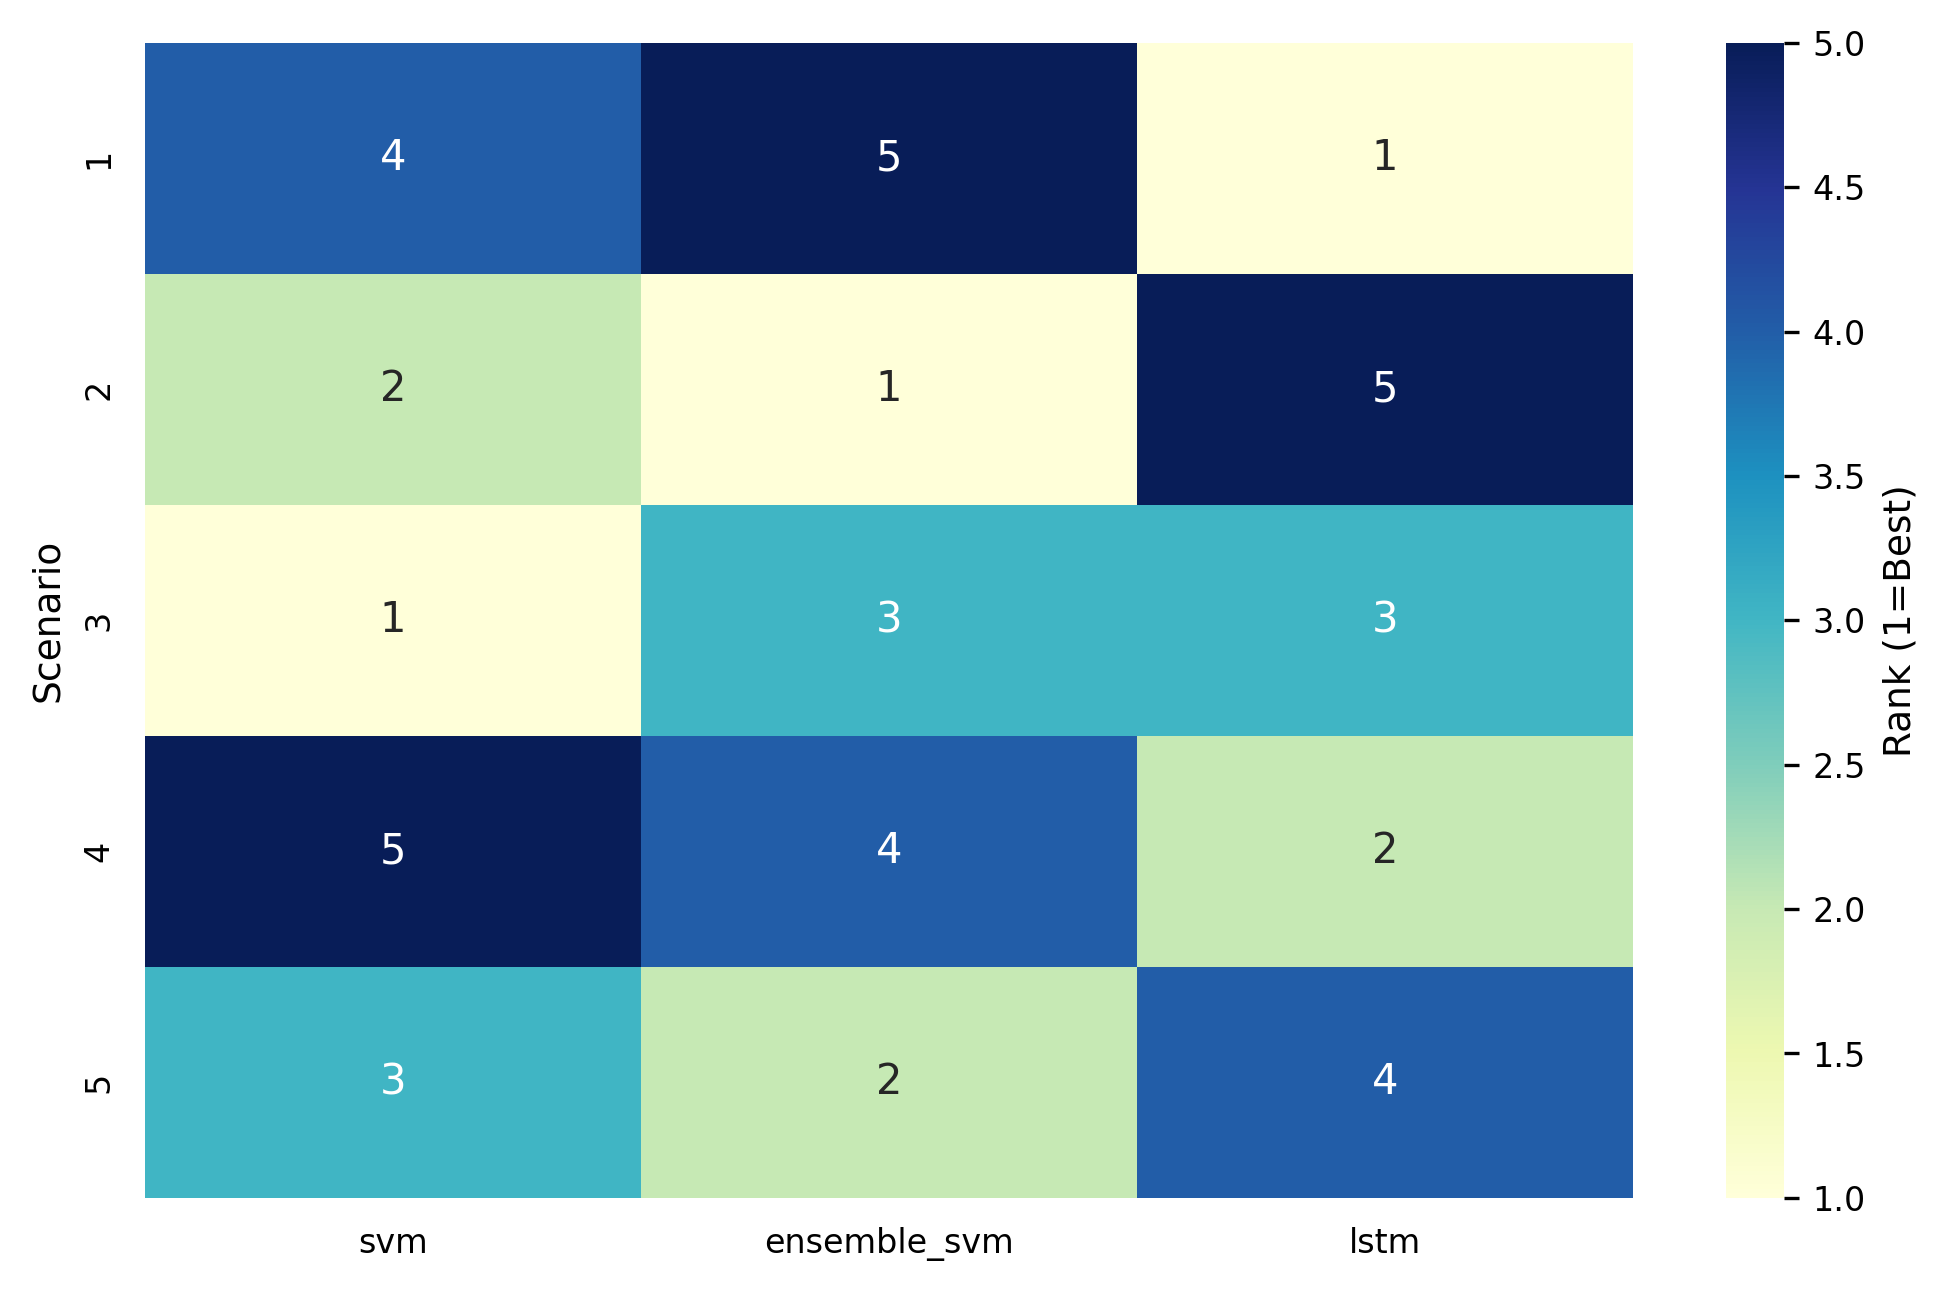

In [54]:
f1_scores = pivot_df.xs('F1_Score', axis=1, level=1)

# Rank the scenarios for each model (1 = best)
ranks = f1_scores.rank(ascending=False).astype(int)

# Prepare for heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    ranks,
    annot=True,
    cmap="YlGnBu",
    cbar_kws={'label': 'Rank (1=Best)'}
)
plt.grid(False)

# Trading simulation

In [67]:
for scenario in range(1, 6):
    globals()[f'results_svm_scenario_{scenario}'] = pd.read_parquet(f"results/res_svm_scenario_{scenario}.pq")
    globals()[f'results_ensemble_svm_scenario_{scenario}'] = pd.read_parquet(f"results/res_ensemble_svm_scenario_{scenario}.pq")

In [68]:
param_config = {}

# Génération dynamique des paramètres
for scenario in range(1, 6):
    svm_result = globals()[f'results_svm_scenario_{scenario}']
    ensemble_result = globals()[f'results_ensemble_svm_scenario_{scenario}']
    
    param_config[float(f"{scenario}.1")] = {
        'window': svm_result["window_size"][0],
        'C_val': svm_result["C"][0]
    }
    param_config[float(f"{scenario}.2")] = {
        'window': ensemble_result["window_size"][0],
        'C_val': ensemble_result["C"][0]
    }

# Mapping stratégie → paramètres fixes
strategies = {
    'svm': {'use_bagging': False, 'key_suffix': '1'},
    'ensemble_svm': {'use_bagging': True, 'key_suffix': '2'}
}

# Mapping investissement → invest_pct et tx_cost
invest_styles = {
    'full': {'invest_pct': 1, 'tx_cost': 0},
    'frac': {'invest_pct': 0.5, 'tx_cost': 0.0005}
}

# Simulation
results = {}

for scenario in range(1, 6):
    dataset = globals()[f'features_df_scenario_{scenario}']
    
    for strat_name, strat_opts in strategies.items():
        strat_key = float(f"{scenario}.{strat_opts['key_suffix']}")
        params = param_config[strat_key]
        
        for invest_name, invest_opts in invest_styles.items():
            result_key = f"{strat_name}_{scenario}_{invest_name}"
            results[result_key] = simulate_svm_trading_returns(
                dataset=dataset,
                window=params['window'],
                C_val=params['C_val'],
                use_bagging=strat_opts['use_bagging'],
                invest_pct=invest_opts['invest_pct'],
                initial_capital=1000.0,
                tx_cost=invest_opts['tx_cost']
            )

summary = []

for scenario in range(1, 6):
    for strat in ['svm', 'ensemble_svm']:
        for invest in ['full', 'frac']:
            key = f"{strat}_{scenario}_{invest}"
            capital = results[key]['Capital_after'].iloc[-1]
            length = len(results[key])
            summary.append({
                'Scenario': scenario,
                'Strategy': strat,
                'Investment': invest,
                'Final_Capital': capital,
                'length_days':length,
                'Capital_per_day': (capital - 1000) / length
            })

summary = pd.DataFrame(summary)

summary_lstm = []
for scenario in range(1, 6):
    for invest in ['full', 'frac']:
        df = pd.read_parquet(f"results/trading_lstm_{scenario}_{invest}.pq")
        capital = df['Capital_after'].iloc[-1]
        length = len(df)
        summary_lstm.append({
                'Scenario': scenario,
                'Strategy': 'lstm',
                'Investment': invest,
                'Final_Capital': capital,
                'length_days':length,
                'Capital_per_day': (capital - 1000) / length
            })
        
summary_lstm = pd.DataFrame(summary_lstm)
summary = pd.concat([summary, summary_lstm], ignore_index=True)
display(summary.head())

Scenario      Strategy Investment  Final_Capital  length_days  \
0         1           svm       full    1284.293840          462   
1         1           svm       frac     919.084121          462   
2         1  ensemble_svm       full    1002.360693          462   
3         1  ensemble_svm       frac     811.703893          462   
4         2           svm       full    1237.778782          462   

   Capital_per_day  
0         0.615355  
1        -0.175143  
2         0.005110  
3        -0.407567  
4         0.514673

In [285]:
(
    summary
    .groupby(['Scenario', 'Strategy'])
    .agg(
        final_capital=('Final_Capital', 'last'),
        capital_per_day=('Capital_per_day', 'last'),
    ).stack()  # pour faire apparaître les stats en "niveau colonne"
    .unstack('Strategy')  # les stratégies deviennent sous-colonnes
    .unstack(-1)
    ).to_latex("tab/summary_results.tex", float_format="%.2f", index=True, multicolumn=True)

In [150]:
summary_capital = []

for scenario in range(1, 6):
    for strat in ['svm', 'ensemble_svm']:
        for invest in ['full', 'frac']:
            key = f"{strat}_{scenario}_{invest}"
            df = results[key].reset_index()
            df_tmp = df[['Date', 'Capital_before']].copy()
            df_tmp['Strategy'] = key  # nom de la combinaison
            summary_capital.append(df_tmp)

# Concaténation de tous les DataFrames
summary_df = pd.concat(summary_capital, ignore_index=True)

summary_capital_lstm = []

for scenario in range(1, 6):
    for strat in ['lstm']:
        for invest in ['full', 'frac']:
            key = f"{strat}_{scenario}_{invest}"
            df = pd.read_parquet(f"results/trading_lstm_{scenario}_{invest}.pq").reset_index()
            df_tmp = df[['Date', 'Capital_before']].copy()
            df_tmp['Strategy'] = key  # nom de la combinaison
            summary_capital_lstm.append(df_tmp)

# Concaténation de tous les DataFrames
summary_df_lstm = pd.concat(summary_capital_lstm, ignore_index=True)

summary_df = pd.concat([summary_df, summary_df_lstm], ignore_index=True).sort_values(by=['Strategy','Date'])
summary_df

Date  Capital_before             Strategy
1386 2020-04-28     1000.000000  ensemble_svm_1_frac
1387 2020-04-29     1015.922683  ensemble_svm_1_frac
1388 2020-04-30     1004.698748  ensemble_svm_1_frac
1389 2020-05-01      996.108980  ensemble_svm_1_frac
1390 2020-05-04     1002.657730  ensemble_svm_1_frac
...         ...             ...                  ...
7849 2022-02-17      816.319999           svm_5_full
7850 2022-02-18      823.957304           svm_5_full
7851 2022-02-22      838.633872           svm_5_full
7852 2022-02-23      860.324295           svm_5_full
7853 2022-02-24      845.973999           svm_5_full

[10158 rows x 3 columns]

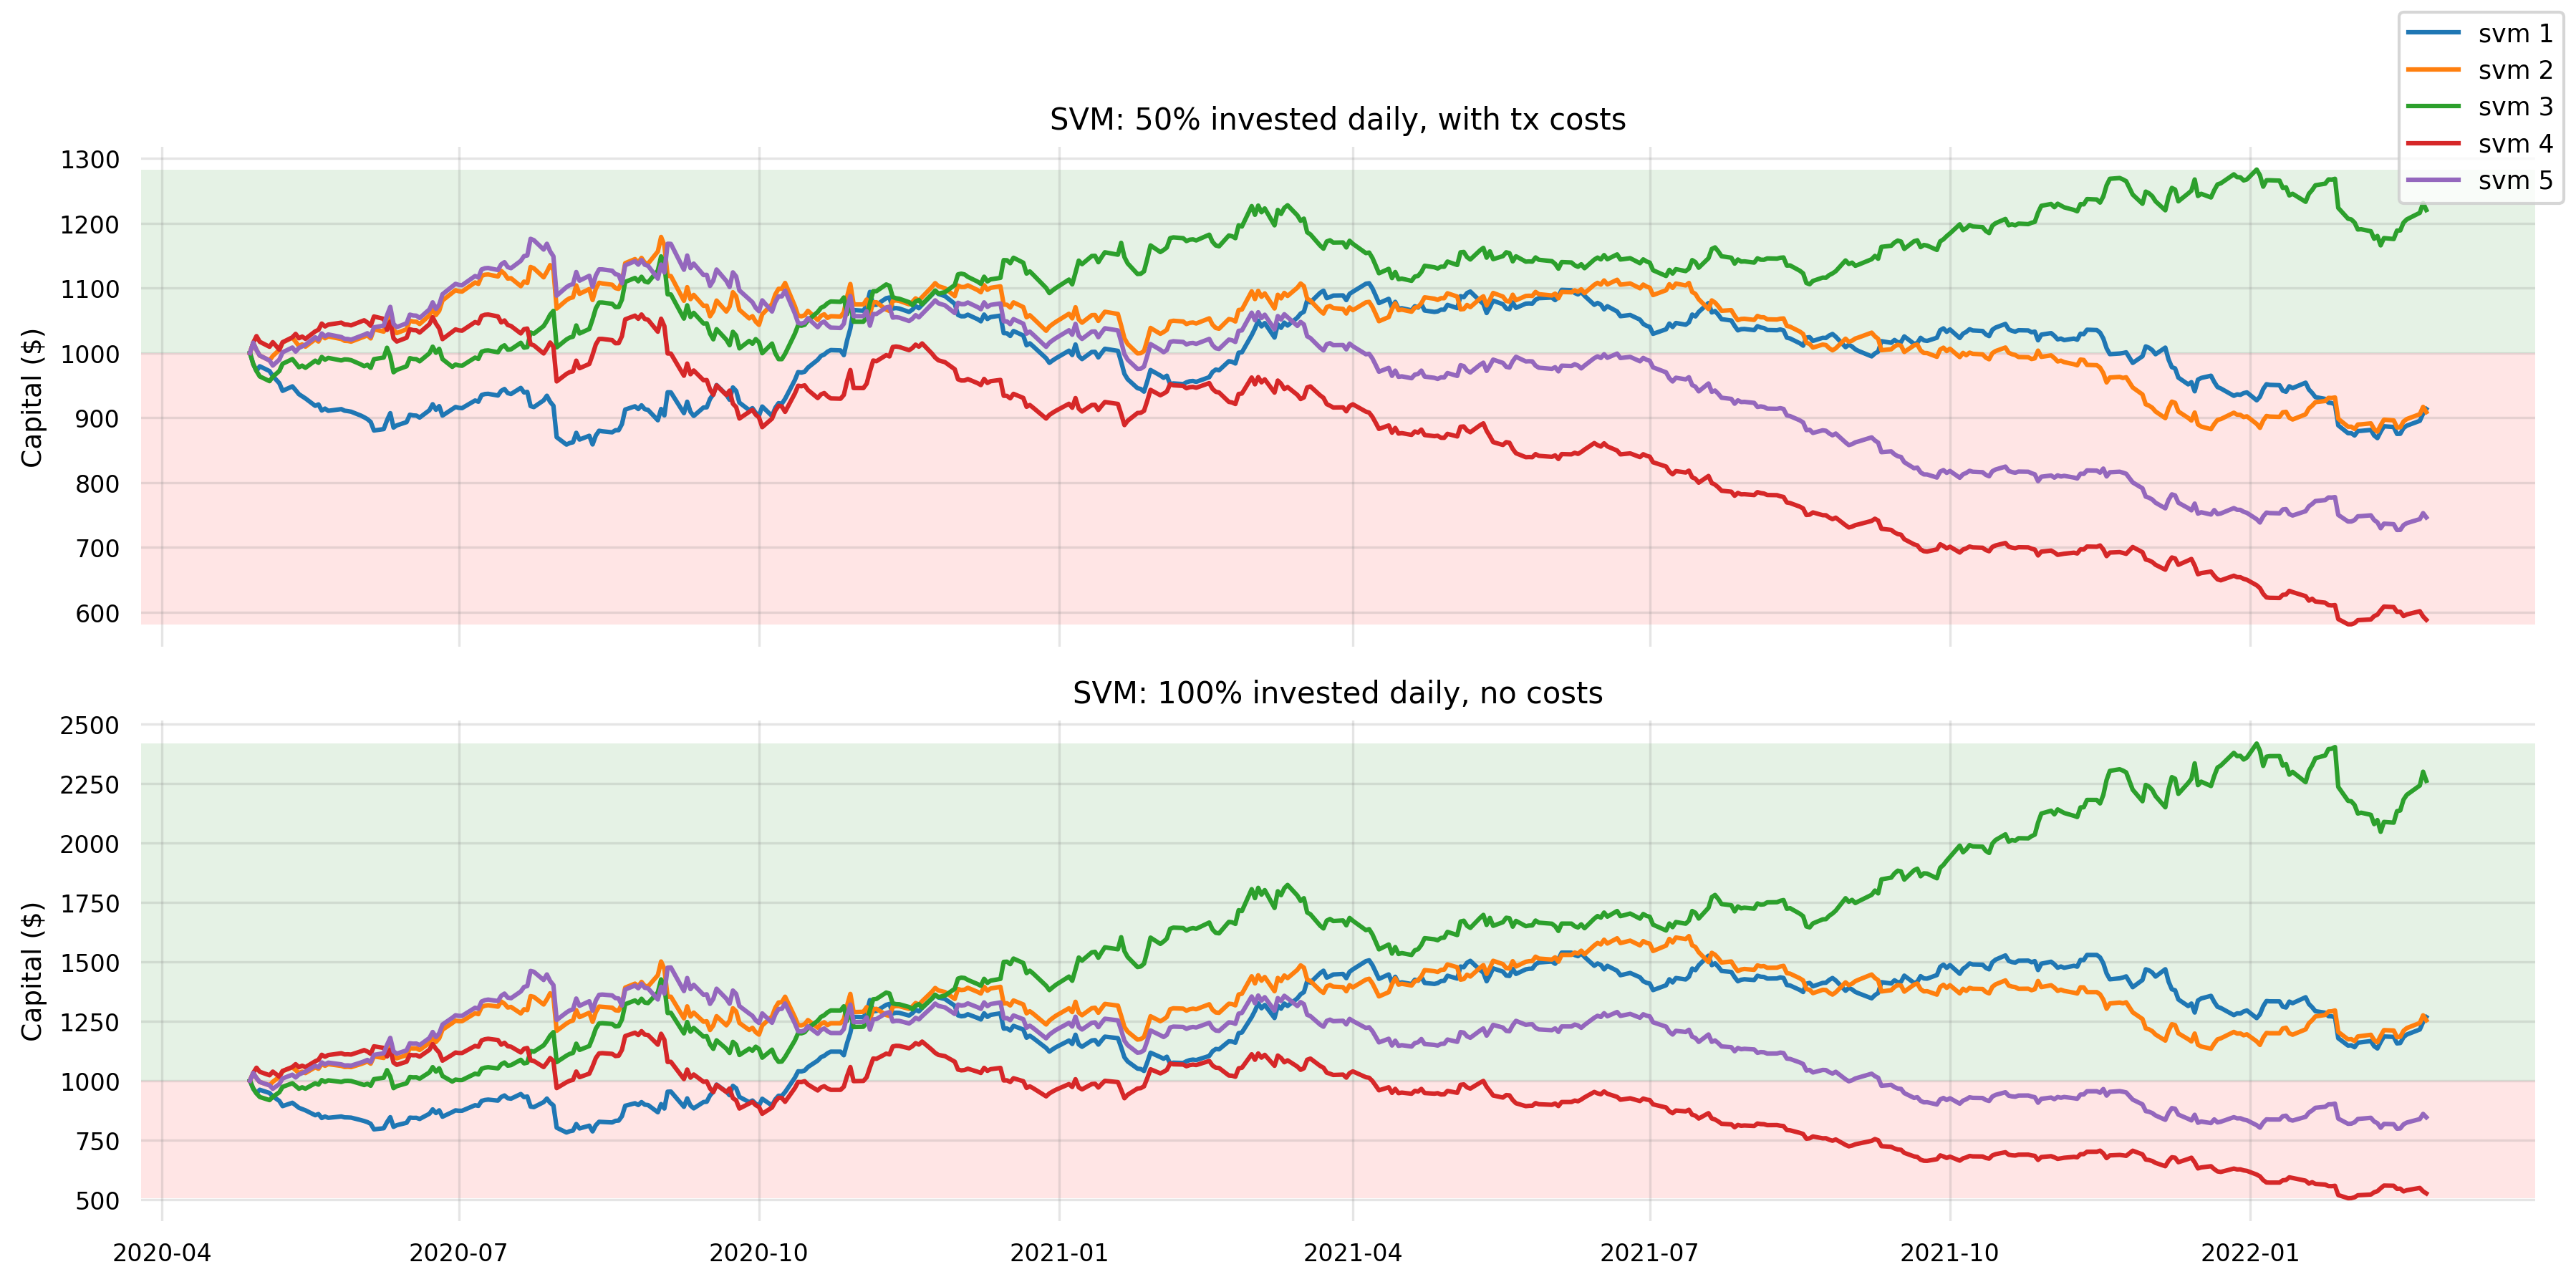

In [258]:
plot_strategy_comparison(summary_df, strategy_prefix='svm')

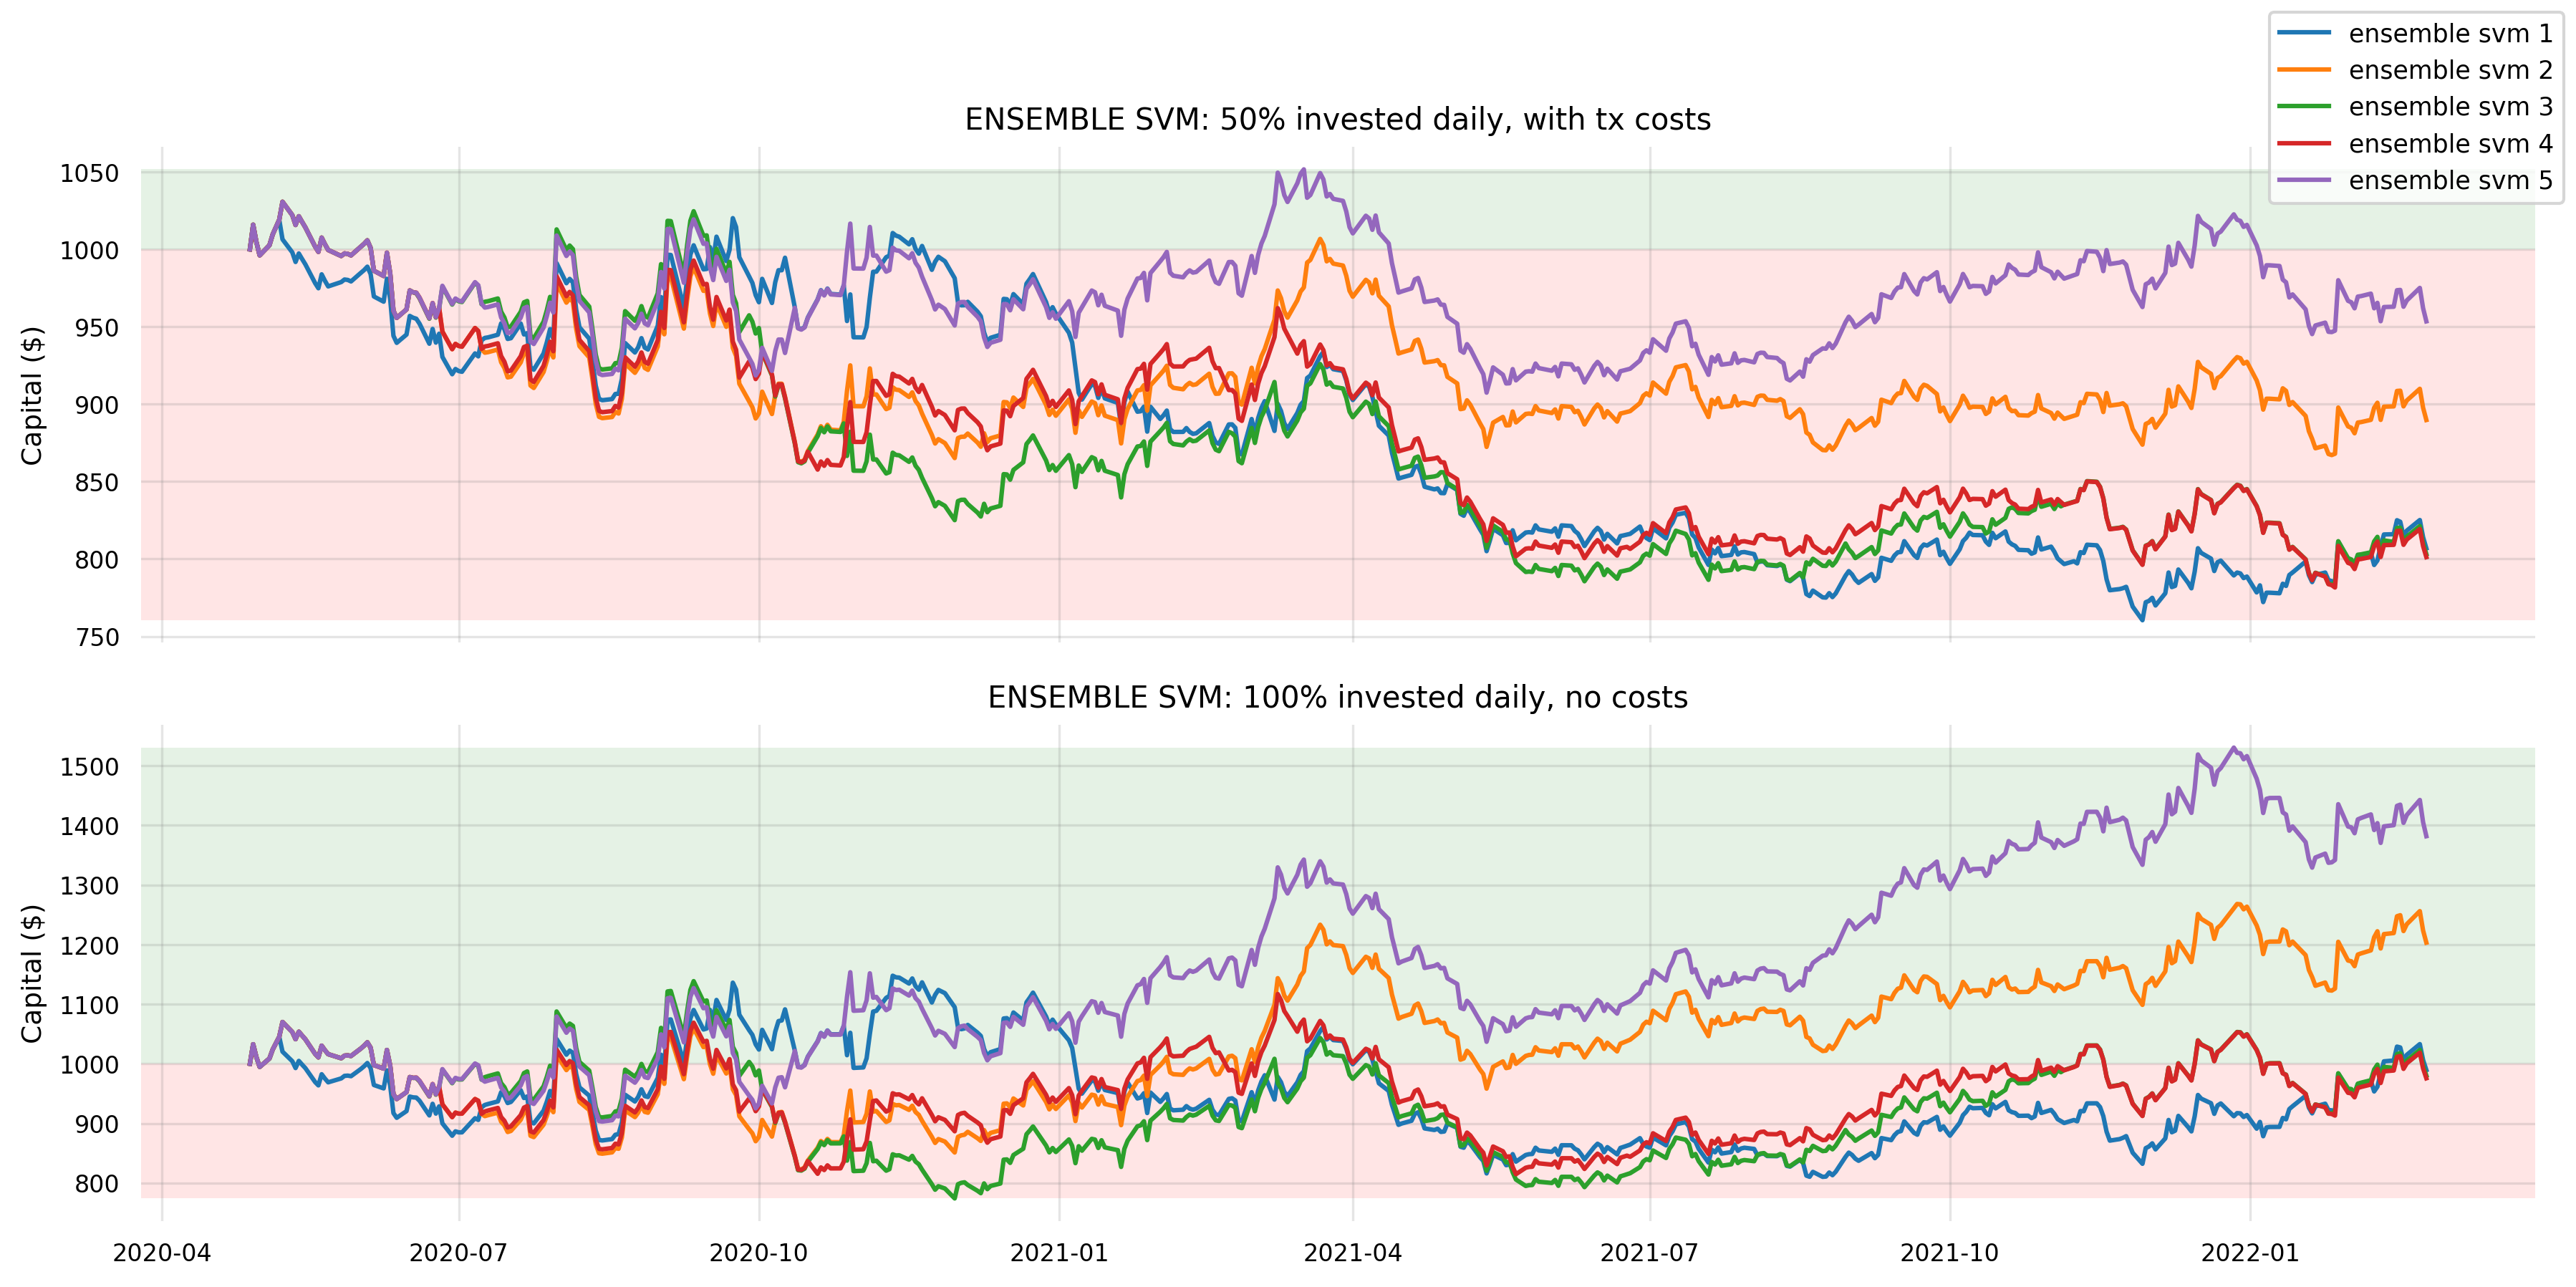

In [259]:
plot_strategy_comparison(summary_df, strategy_prefix='ensemble_svm')

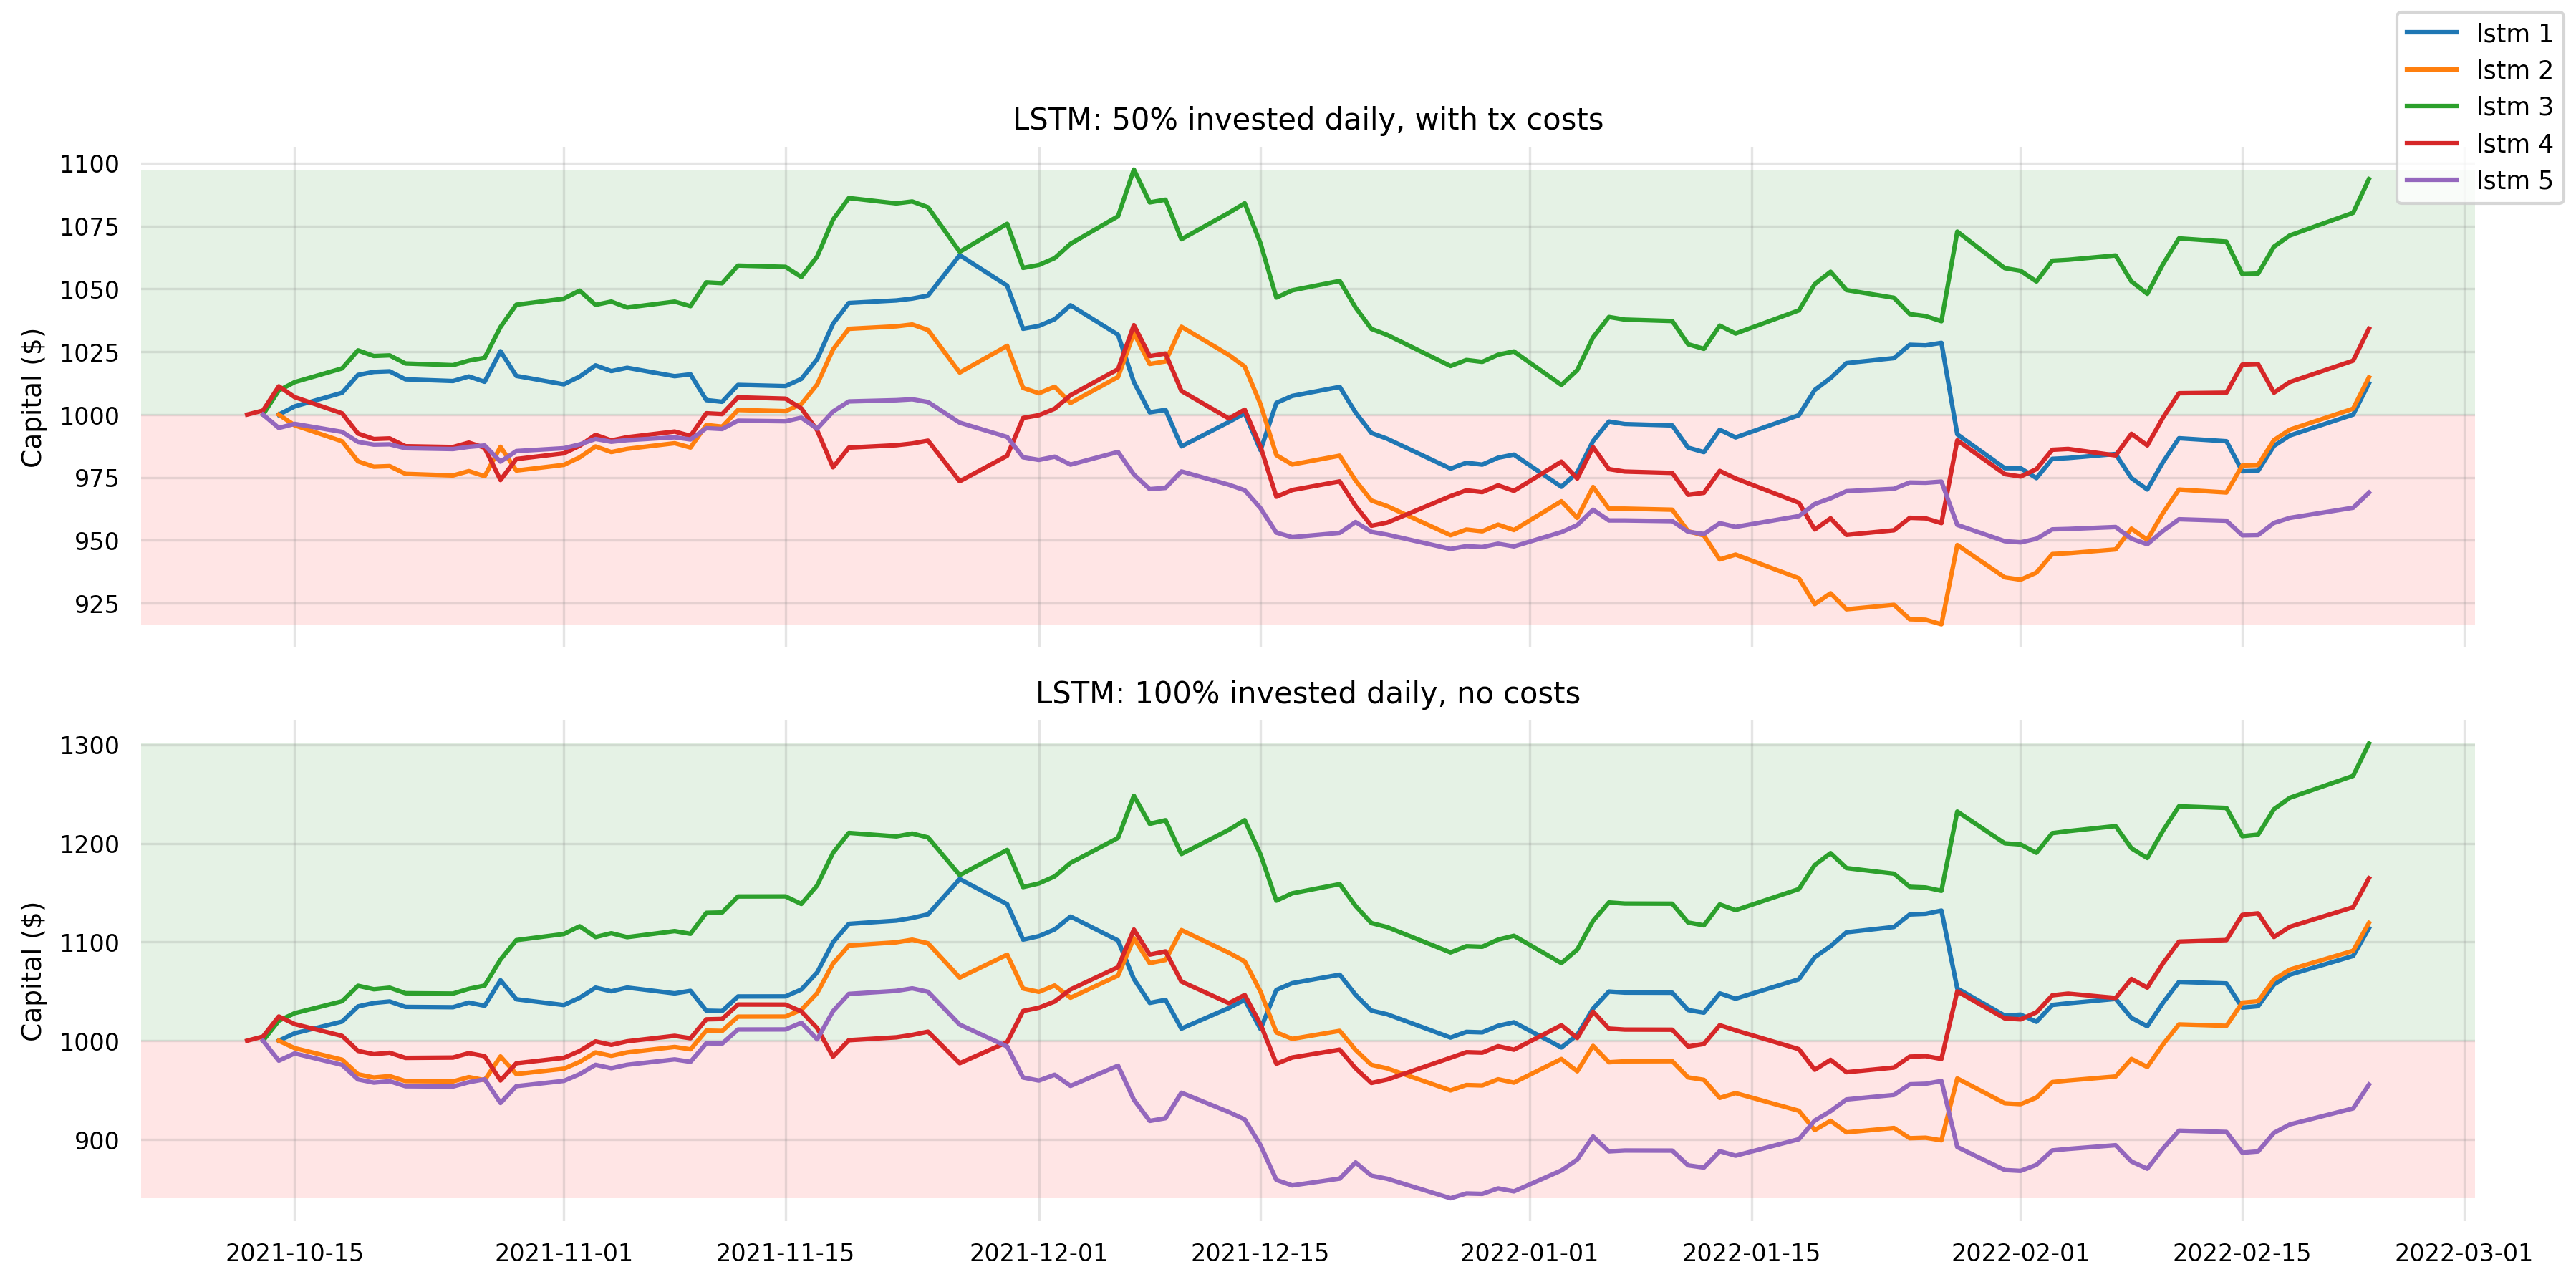

In [260]:
plot_strategy_comparison(summary_df, strategy_prefix='lstm')

Important lose of money for lstm 1